In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install pydantic==1.10.3
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 894.6/894.6 kB 33.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 69.2.0
    Uninstalling setuptools-69.2.0:
      Successfully uninstalled setuptools-69.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dash 2.16.1 requires dash-core-components==2.0.0, which is not installed.
dash 2.16.1 requires dash-html-components==2.0.0, which is not installed.
dash 2.16.1 requires dash-table==5.0.0, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 12.4 MB/s eta 0:00:00
Reason for being yanked: See https://github.com/py

In [11]:
# Dowmload and unzip 'Bike Sharing Demand' dataset from Kaggle

# Install Kaggle API client
!pip install -q Kaggle

# Upload Kaggle API token (json file) -- (Uncomment) Only for Google Colab (For AWS Sagemaker upload 'kaggle.json')
# from google.colab import files             
# files.upload() 

# create a kaggle directory
!mkdir ~/.kaggle          # (-----------------------------------------   Uncomment - For first time only)

# copy 'kaggle.json' (Kaggle API Token) to the folder we have created
!cp kaggle.json ~/.kaggle/

# Authorize permissions for the json to act
!chmod 600 ~/.kaggle/kaggle.json

# Download the Bike Sharing Demand dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand

# # Unzip Dataset (Over-write to avoid error, if the dataset pre-exists)
!unzip -o bike-sharing-demand.zip    # -o: over-writes if the file pre-exists

mkdir: cannot create directory ‘/home/sagemaker-user/.kaggle’: File exists
100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 519kB/s]
100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 518kB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [3]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor

In [4]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv",parse_dates=["datetime"])

In [5]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
# Train dataset summary
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [8]:
# Check for null values in train data
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [9]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv",parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [10]:
# Checking all the features and target variable in the dataset
print("Columns in Train Dataset:\n", train.columns)
print("\nColumns in Test Dataset:\n", test.columns)

Columns in Train Dataset:
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

Columns in Test Dataset:
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')


In [11]:
# Variables not present in test dataset
print("Variables that are not present in the test dataset: ")
list(set(train.columns).difference(set(test.columns)))

Variables that are not present in the test dataset: 


['casual', 'registered', 'count']

In [12]:
# Requirements: For AutoGluon's Tabular Predictions
eval_metric = 'root_mean_squared_error' 
label = 'count'
ignored_columns = ["casual", "registered"]   # Ignored columns while training
train_data = train                           # 'casual' and 'registered' columns are already dropped/ignored
time_limit = 600                             # 10 minutes -> 60*10 = 600 seconds
presets = "best_quality"                     # auto_stack=True

In [13]:
predictor = TabularPredictor(label=label, 
                             problem_type= 'regression', 
                             eval_metric=eval_metric, 
                             learner_kwargs={'ignored_columns': ignored_columns}).fit(
                                                                           train_data = train_data,
                                                                           time_limit=time_limit,
                                                                           presets=presets)

No path specified. Models will be saved in: "AutogluonModels/ag-20240424_124754"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240424_124754"
AutoGluon Version:  0.8.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Mar 23 09:49:55 UTC 2024
Disk Space Avail:   5.08 GB / 5.36 GB (94.8%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
/opt/conda/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:215: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", 

In [14]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                    model   score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L3  -52.730199       2.706465  59.363183                0.000538           0.138646            3       True          8
1  RandomForestMSE_BAG_L2  -53.309378       2.112005  49.891958                0.615689          26.984731            2       True          6
2    ExtraTreesMSE_BAG_L2  -53.451431       2.090238  32.239805                0.593922           9.332578            2       True          7
3   KNeighborsDist_BAG_L1  -84.125061       0.060153   0.040104                0.060153           0.040104            1       True          2
4     WeightedEnsemble_L2  -84.125061       0.060748   0.273248                0.000595           0.233144            2       True          5
5   KNeighborsUnif_BAG_L1 -101.546199       0.055420   0.050795                0.05542

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'RandomForestMSE_BAG_L1': -116.54835939455667,
  'ExtraTreesMSE_BAG_L1': -124.60067564699747,
  'WeightedEnsemble_L2': -84.12506123181602,
  'RandomForestMSE_BAG_L2': -53.30937847291498,
  'ExtraTreesMSE_BAG_L2': -53.45143074386139,
  'WeightedEnsemble_L3': -52.730199076200954},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'KNeighborsUnif_BAG_L1': ['KNeighborsUnif_BAG_L1'],
  'KNeighborsDist_BAG_L1': ['KNeighborsDist_BAG_L1'],

In [15]:
# Leaderboard dataframe
leaderboard_df = pd.DataFrame(predictor.leaderboard(silent=True))
leaderboard_df

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-52.730199,2.706465,59.363183,0.000538,0.138646,3,True,8
1,RandomForestMSE_BAG_L2,-53.309378,2.112005,49.891958,0.615689,26.984731,2,True,6
2,ExtraTreesMSE_BAG_L2,-53.451431,2.090238,32.239805,0.593922,9.332578,2,True,7
3,KNeighborsDist_BAG_L1,-84.125061,0.060153,0.040104,0.060153,0.040104,1,True,2
4,WeightedEnsemble_L2,-84.125061,0.060748,0.273248,0.000595,0.233144,2,True,5
5,KNeighborsUnif_BAG_L1,-101.546199,0.055420,0.050795,0.055420,0.050795,1,True,1
6,RandomForestMSE_BAG_L1,-116.548359,0.549593,14.753183,0.549593,14.753183,1,True,3
7,ExtraTreesMSE_BAG_L1,-124.600676,0.831151,8.063145,0.831151,8.063145,1,True,4


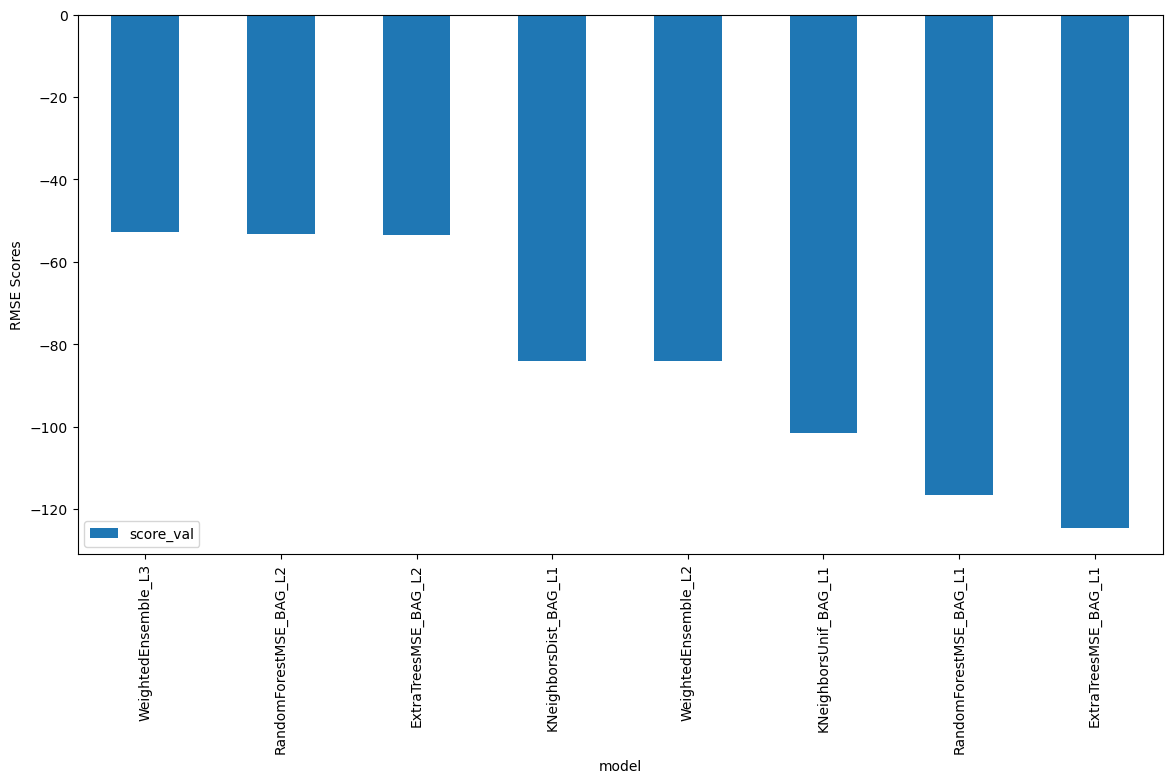

In [16]:
# Output the model's `score_val` in a bar chart to compare performance
import matplotlib.pyplot as plt
leaderboard_df.plot(kind="bar", x="model", y="score_val", figsize=(14, 7))
plt.ylabel("RMSE Scores")
plt.show()

In [17]:
predictions = predictor.predict(test)
predictions.head()

0    22.444073
1    41.671574
2    45.626762
3    46.568428
4    50.585464
Name: count, dtype: float32

In [18]:
predictions.describe()

count    6493.000000
mean      100.191887
std        90.330627
min         2.130000
25%        19.085648
50%        62.764816
75%       169.132050
max       358.224182
Name: count, dtype: float64

In [19]:
# How many negative values do we have?

# Rechecking the predictions
negative_pred_count = predictions.apply(lambda x: 1 if x<0 else 0)

pred_pos_count = (negative_pred_count==0).sum()
pred_neg_count = (negative_pred_count==1).sum()

print("Total predictions                :", len(predictions.index))
print("Total positive prediction values :", pred_pos_count)
print("Total negative prediction values :", pred_neg_count)

Total predictions                : 6493
Total positive prediction values : 6493
Total negative prediction values : 0


In [20]:
# Set them to zero 
predictions[predictions<0] = 0    # (In case, if negative values exist in the predictions, set them to 0)

# Rechecking, if no predictions are less than 0
negative_pred_count = predictions.apply(lambda x: 1 if x<0 else 0)
pred_neg_count = (negative_pred_count==1).sum()
print(f"No. of negative predictions: {pred_neg_count}")
print("All negative values in the predictions (if any) are set to zero successfully.")

No. of negative predictions: 0
All negative values in the predictions (if any) are set to zero successfully.


In [43]:
submission = pd.DataFrame()
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [44]:
!kaggle competitions submit -c bike-sharing-demand -f sampleSubmission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 140k/140k [00:00<00:00, 192kB/s]
Successfully submitted to Bike Sharing Demand

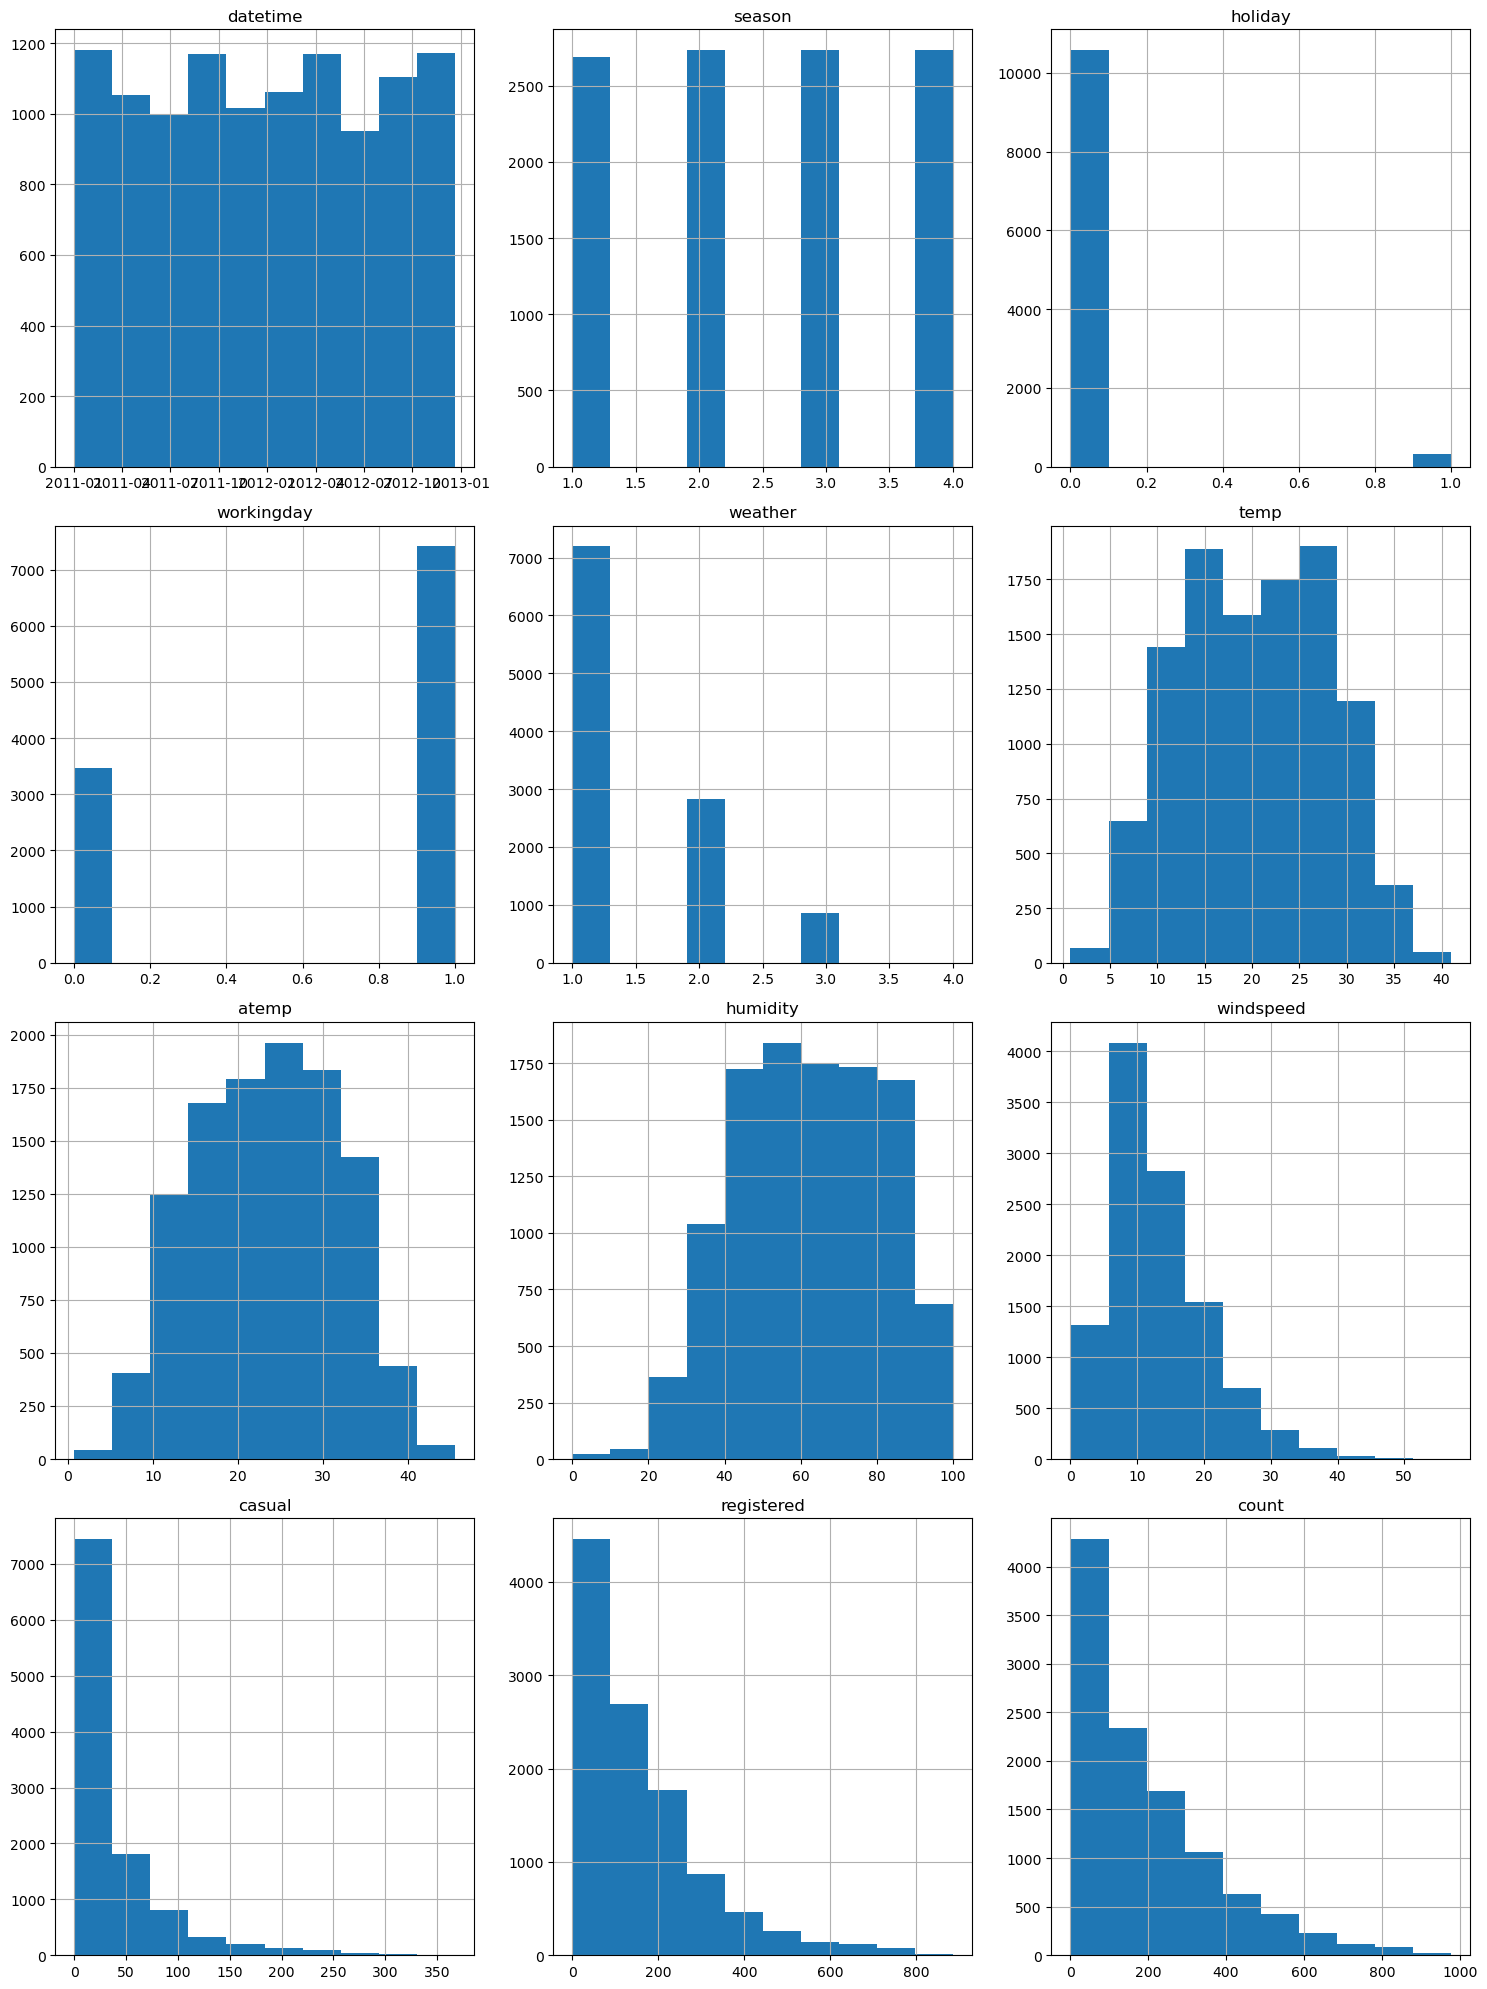

In [45]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(15,20))  # Note: 'casual' and 'registered' are ignored during training as they are absent in test data

plt.tight_layout()
plt.show()

In [46]:
!pip install seaborn


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 1800x1800 with 0 Axes>

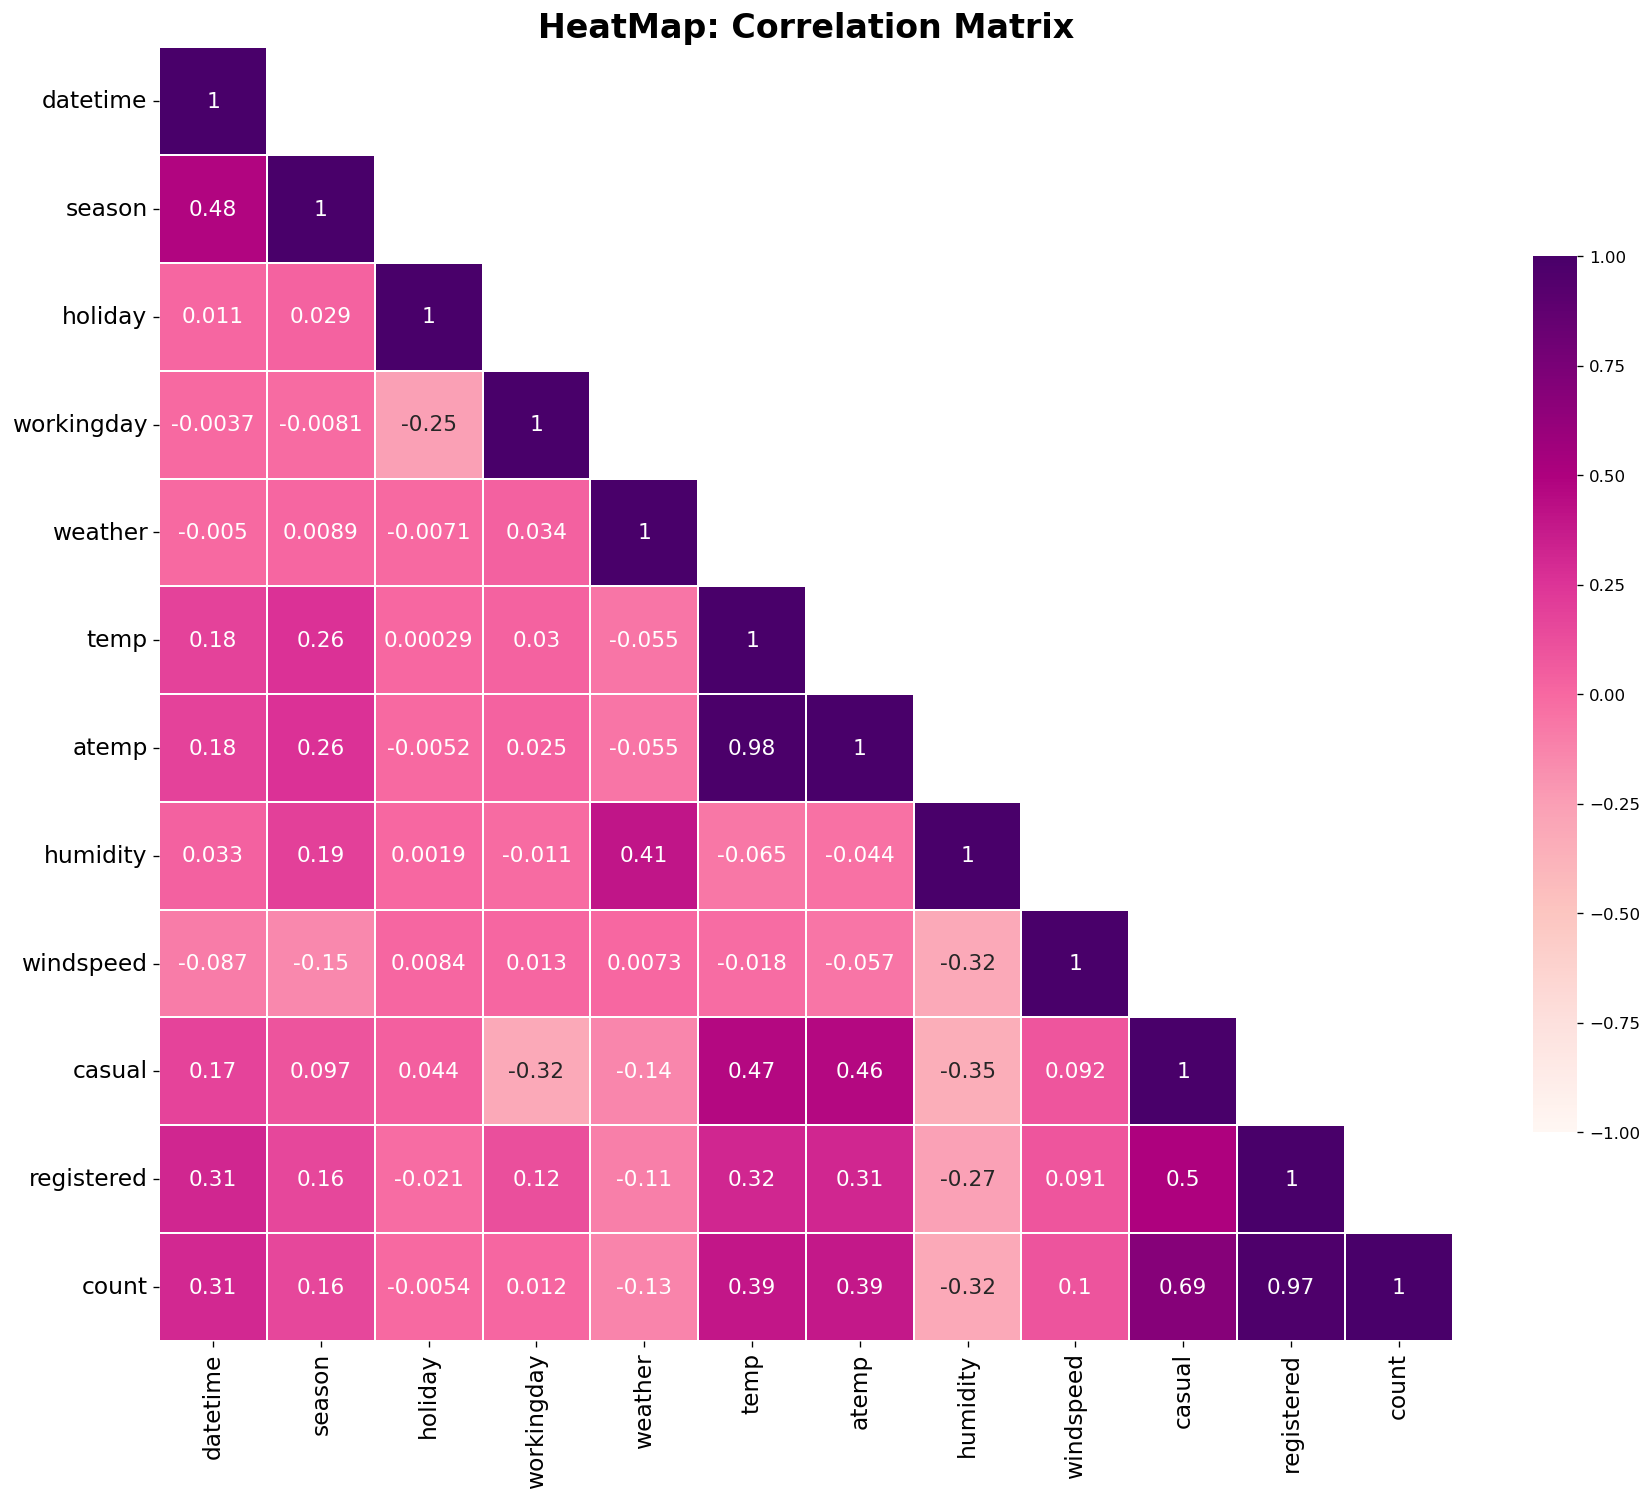

In [48]:
## Let's check the correlation between these variables to see if there is pattern between variables

#Plotting a heatmap to understand the correlation between the independent variables

plt.figure(figsize = (15,15), dpi=120)
corr_data = train.copy()

corr_matrix = corr_data.corr()
f, ax_corr1 = plt.subplots(figsize=(15, 15), dpi=120)
# Create a mask to eliminate redundant repetitive correlations
corr_mask = np.array(corr_matrix)
corr_mask[np.tril_indices_from(corr_mask)] = False

# Plot heatmap using correlation matrix and mask
ax_corr1 = sns.heatmap(corr_matrix, cmap= 'RdPu', cbar_kws={"shrink": .5}, vmin= -1, vmax=1, center=0,
            square=True, mask=corr_mask, annot=True, linewidths=0.01, annot_kws={"size":13})
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=0)
plt.title("HeatMap: Correlation Matrix", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.autoscale()
plt.show()

In [49]:
# Checking 'datetime' feature in train data
train['datetime'].head()

0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
3   2011-01-01 03:00:00
4   2011-01-01 04:00:00
Name: datetime, dtype: datetime64[ns]

In [50]:
# Splitting the 'datetime' feature in train data
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.dayofweek  # Note: day -> dayofweek (0->Monday, 6->Sunday)
train["hour"] = train["datetime"].dt.hour
train.drop(["datetime"], axis=1, inplace=True)     # Drop 'datetime' feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,5,4


In [51]:
# Splitting the 'datetime' feature in test data
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.dayofweek  # Note: day -> dayofweek (0->Monday, 6->Sunday)
test["hour"] = test["datetime"].dt.hour
test.drop(["datetime"], axis=1, inplace=True)   # Drop 'datetime' feature
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,3,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,1
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,2
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,4


In [52]:
# Recheck datatype of features in the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
 11  year        10886 non-null  int32  
 12  month       10886 non-null  int32  
 13  day         10886 non-null  int32  
 14  hour        10886 non-null  int32  
dtypes: float64(3), int32(4), int64(8)
memory usage: 1.1 MB


In [53]:
# Convert 'int' feature columns that are categorical in nature to 'category' type
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")

test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [54]:
# View the new features
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,5,4


In [55]:
# Recheck datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  int64   
 2   workingday  10886 non-null  int64   
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  count       10886 non-null  int64   
 11  year        10886 non-null  int32   
 12  month       10886 non-null  int32   
 13  day         10886 non-null  int32   
 14  hour        10886 non-null  int32   
dtypes: category(2), float64(3), int32(4), int64(6)
memory usage: 957.3 KB


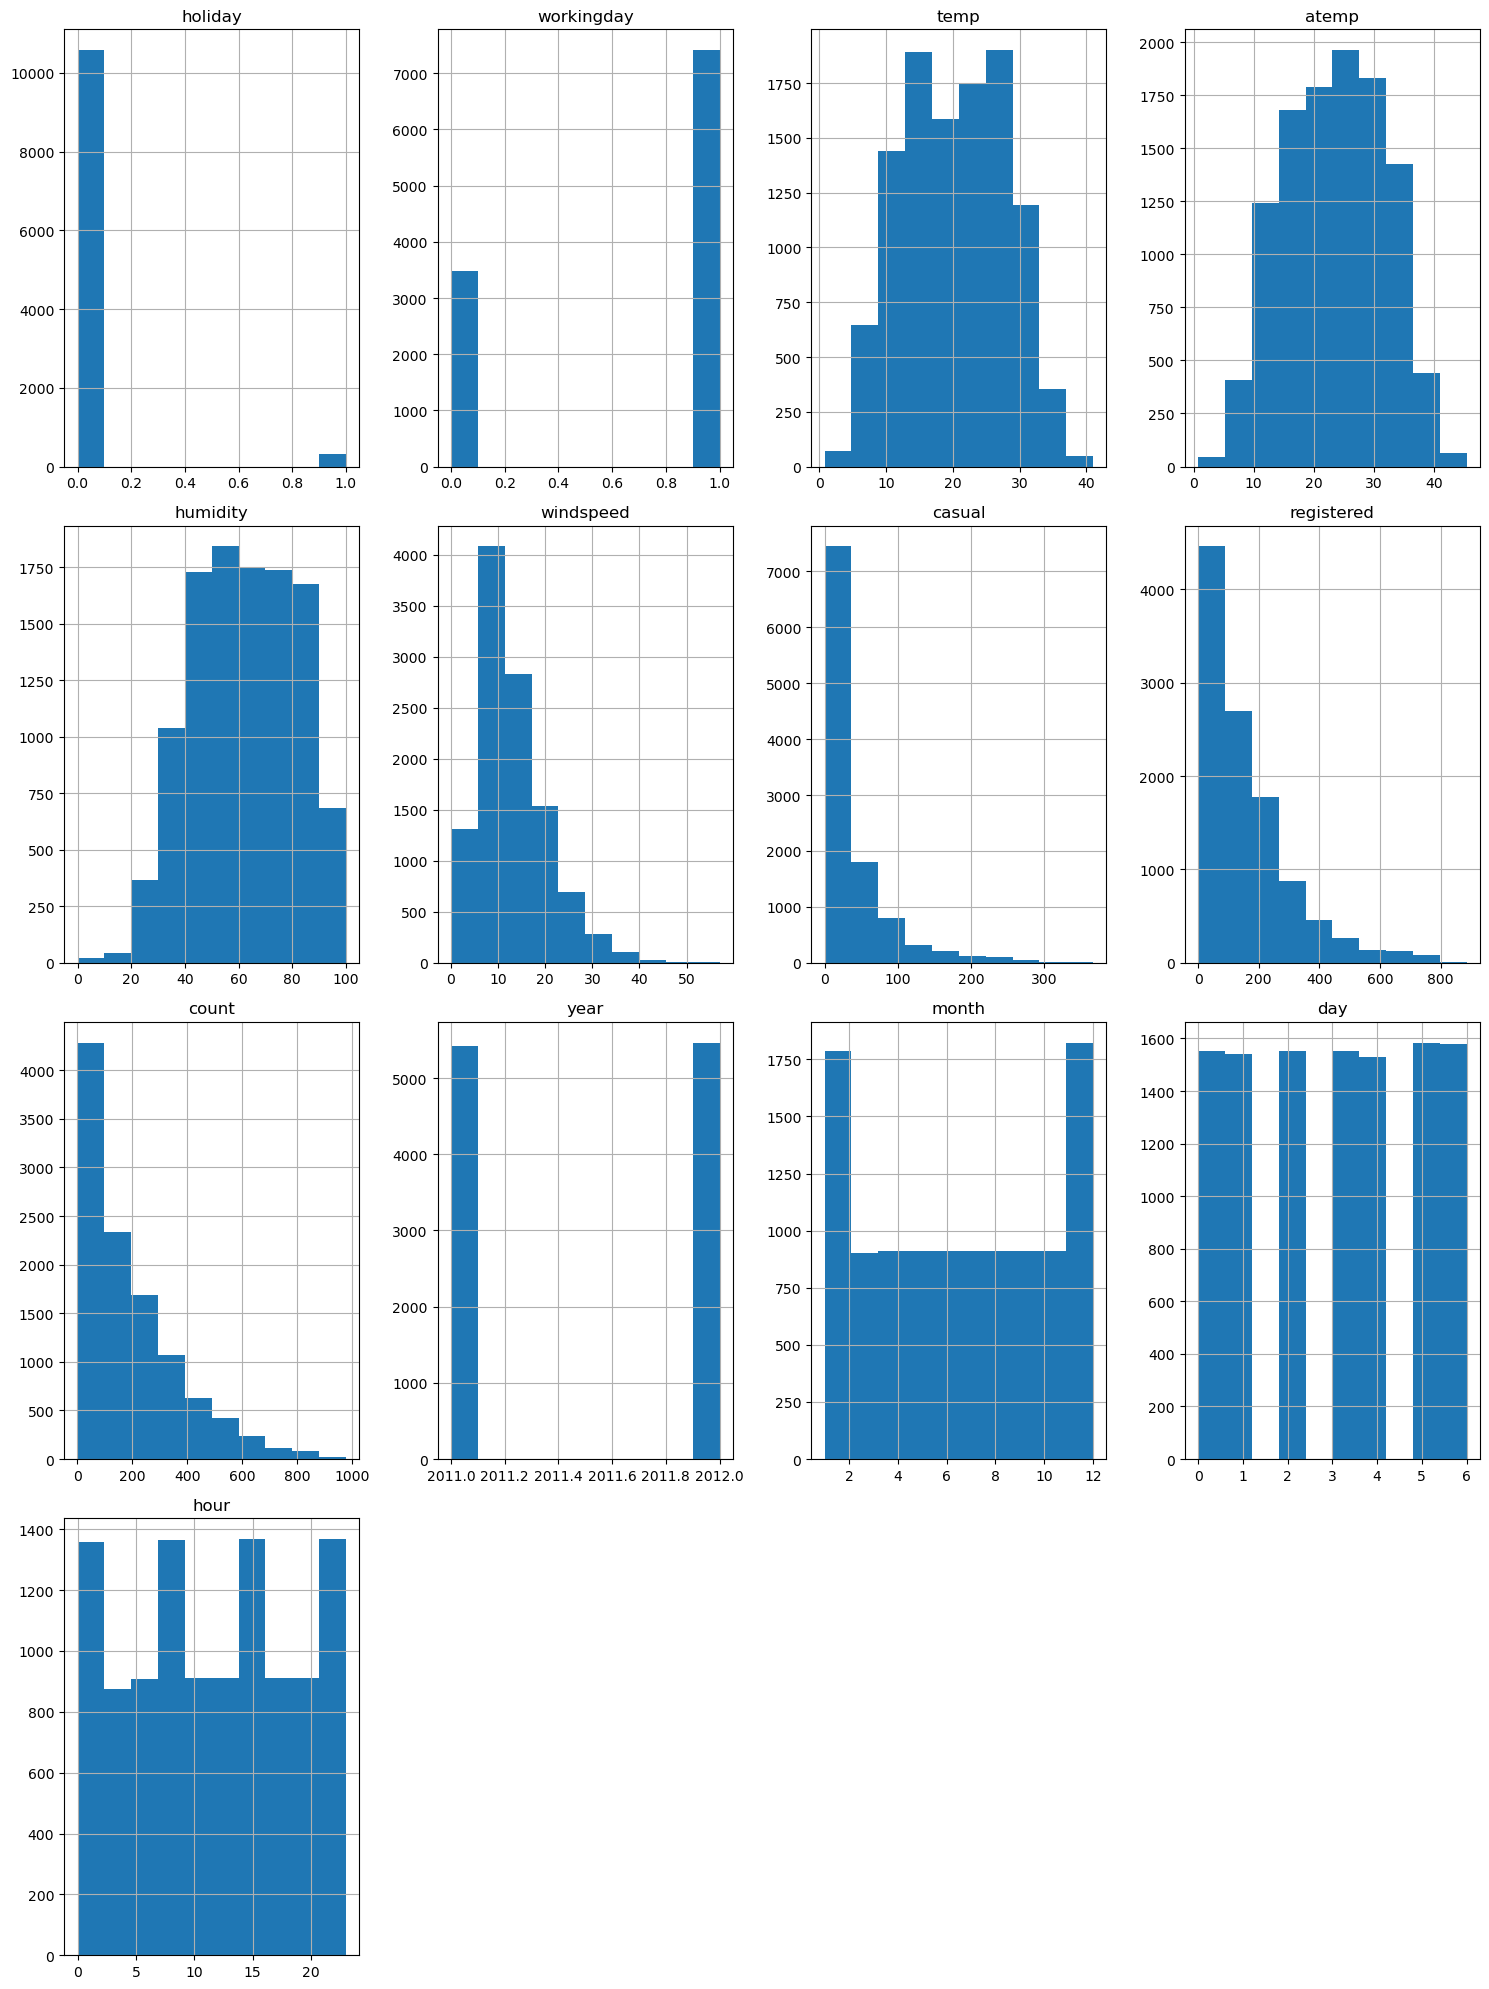

In [56]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15,20))  # Note: 'casual' and 'registered' are ignored during training as they are absent in test data

plt.tight_layout()
plt.show()

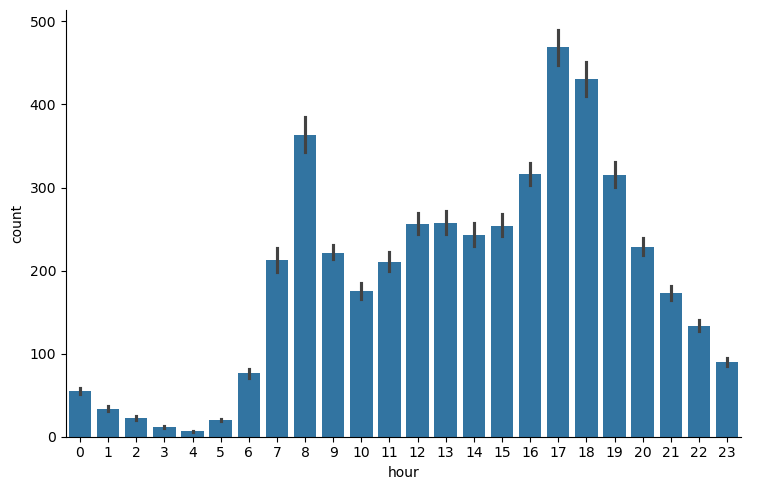

In [57]:
# Variation in`count` w.r.t `hour`

# Using catplot: 'kind':bar makes sure to take value of 'count' for every record into account
sns.catplot(x="hour",y="count",data=train,kind='bar',height=5,aspect=1.5) 
plt.tight_layout()
plt.show()

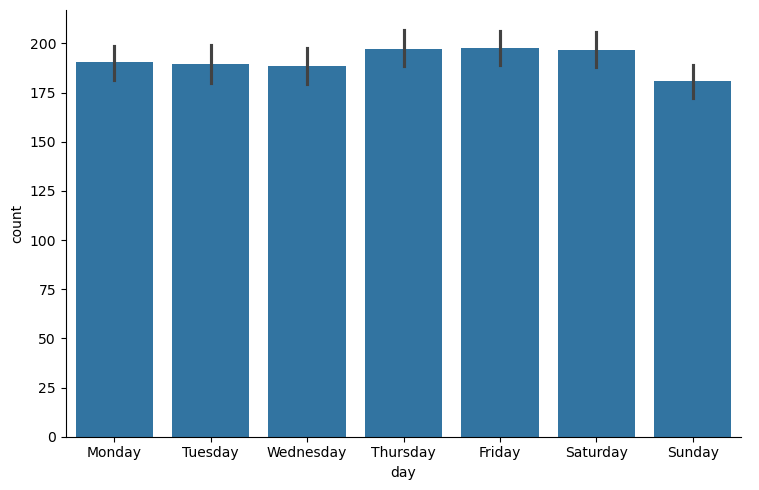

In [58]:
# Variation in`count` w.r.t `day` (dayofweek) [0: Monday -> 6: Sunday]

# Using catplot: 'kind':bar makes sure to take value of 'count' for every record into account
sns.catplot(x="day",y="count",data=train,kind='bar',height=5,aspect=1.5) 
plt.tight_layout()
plt.xticks(ticks=range(0,7), labels=["Monday", "Tuesday", "Wednesday", 
                                     "Thursday", "Friday", "Saturday", "Sunday"])
plt.show()

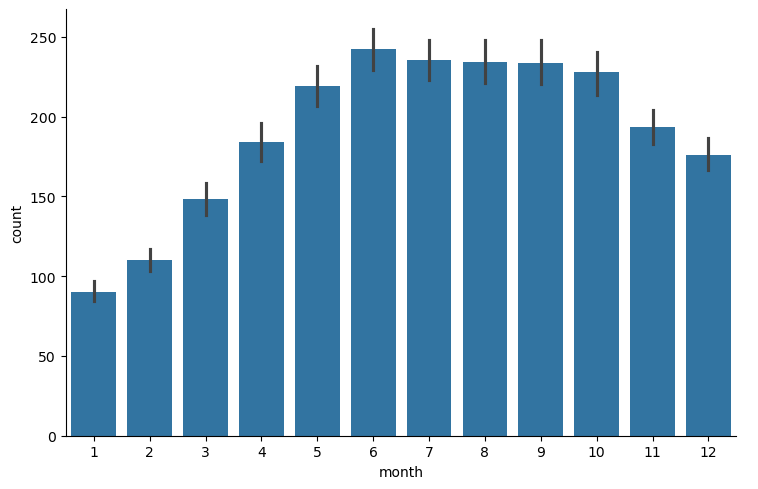

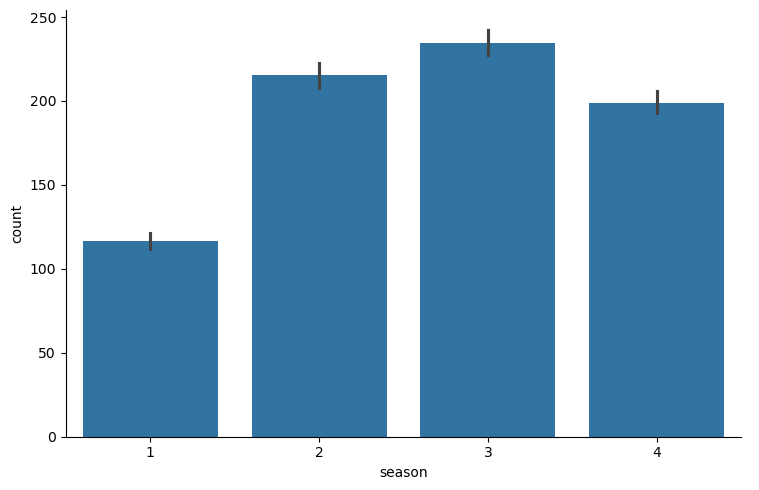

In [59]:
# Variation in`count` w.r.t `month` and 'season'

# Using catplot: 'kind':bar makes sure to take value of 'count' for every record into account
sns.catplot(x="month",y="count",data=train,kind='bar',height=5,aspect=1.5) 
sns.catplot(x="season",y="count",data=train,kind='bar',height=5,aspect=1.5)
plt.tight_layout()
plt.show()

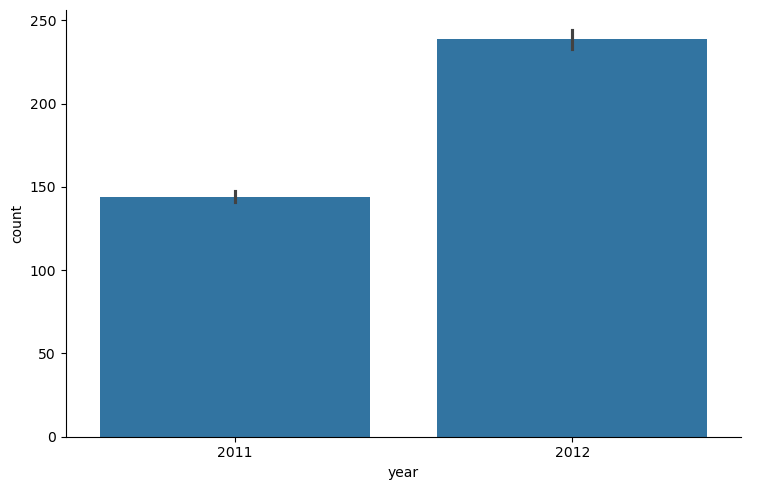

In [60]:
# Variation in`count` w.r.t `year`

# Using catplot: 'kind':bar makes sure to take value of 'count' for every record into account
sns.catplot(x="year",y="count",data=train,kind='bar',height=5,aspect=1.5)
plt.tight_layout()
plt.show()

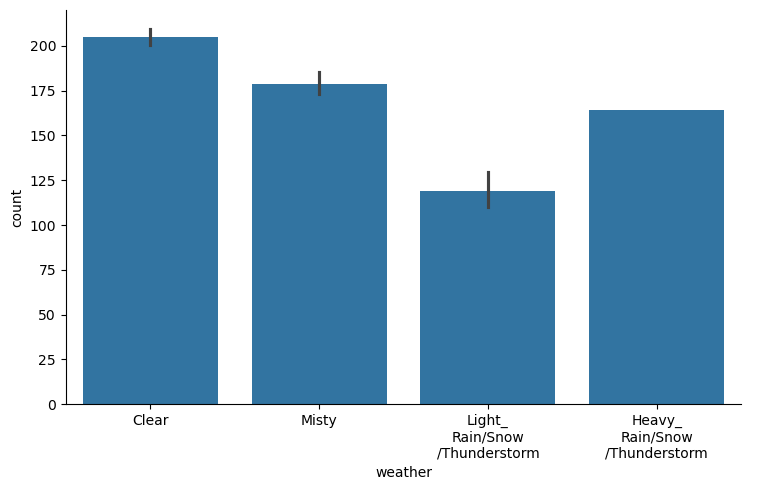

In [61]:
# Variation in`count` w.r.t `weather'

# Using catplot: 'kind':bar makes sure to take value of 'count' for every record into account
sns.catplot(x="weather",y="count",data=train,kind='bar',height=5,aspect=1.5) 
plt.xticks(ticks=range(0,4), labels=["Clear","Misty", 
                                     "Light_\nRain/Snow\n/Thunderstorm", 
                                     "Heavy_\nRain/Snow\n/Thunderstorm"])
plt.tight_layout()
plt.show()

In [62]:
# New feature 'day_type' contains categories 'weekend', 'weekday', or 'holiday' (In Train and Test set)

# Adding features - 'day_type' in train data
train["day_type"]=""
train.loc[(train.holiday==1),"day_type"] = "holiday"
train.loc[((train.holiday==0) & (train.workingday==1)), "day_type"] = "weekday"
train.loc[((train.holiday==0) & (train.workingday==0)), "day_type"] = "weekend"

# Adding features - 'day_type' in test data
test["day_type"]=""
test.loc[(test.holiday==1),"day_type"] = "holiday"
test.loc[((test.holiday==0) & (test.workingday==1)), "day_type"] = "weekday"
test.loc[((test.holiday==0) & (test.workingday==0)), "day_type"] = "weekend"

# Change the datatype to category
train["day_type"] = train["day_type"].astype("category")
test["day_type"] = test["day_type"].astype("category")

train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,day_type
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,5,0,weekend
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1,weekend
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,5,2,weekend
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,5,3,weekend
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,5,4,weekend


In [63]:
# Statistics of all features within the trian data
train.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
count,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,3.013963,11.541613
std,0.166599,0.466159,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,2.004585,6.915838
min,0.000000,0.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,1.000000,6.000000
50%,0.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,3.000000,12.000000
75%,0.000000,1.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,5.000000,18.000000
max,1.000000,1.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,6.000000,23.000000


In [64]:
# Dropping highly correlated independent feature 'atemp' from train and test datasets
train.drop(["atemp"], axis=1, inplace=True)
test.drop(["atemp"], axis=1, inplace=True)
# Checking datatypes of variables
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  int64   
 2   workingday  10886 non-null  int64   
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   humidity    10886 non-null  int64   
 6   windspeed   10886 non-null  float64 
 7   casual      10886 non-null  int64   
 8   registered  10886 non-null  int64   
 9   count       10886 non-null  int64   
 10  year        10886 non-null  int32   
 11  month       10886 non-null  int32   
 12  day         10886 non-null  int32   
 13  hour        10886 non-null  int32   
 14  day_type    10886 non-null  category
dtypes: category(3), float64(2), int32(4), int64(6)
memory usage: 883.0 KB


In [65]:
print("(After EDA + Feature Engineering) Train Data Shape : ", train.shape)
print("(After EDA + Feature Engineering) Test Data Shape  : ", test.shape)

(After EDA + Feature Engineering) Train Data Shape :  (10886, 15)
(After EDA + Feature Engineering) Test Data Shape  :  (6493, 12)


<Figure size 1800x1800 with 0 Axes>

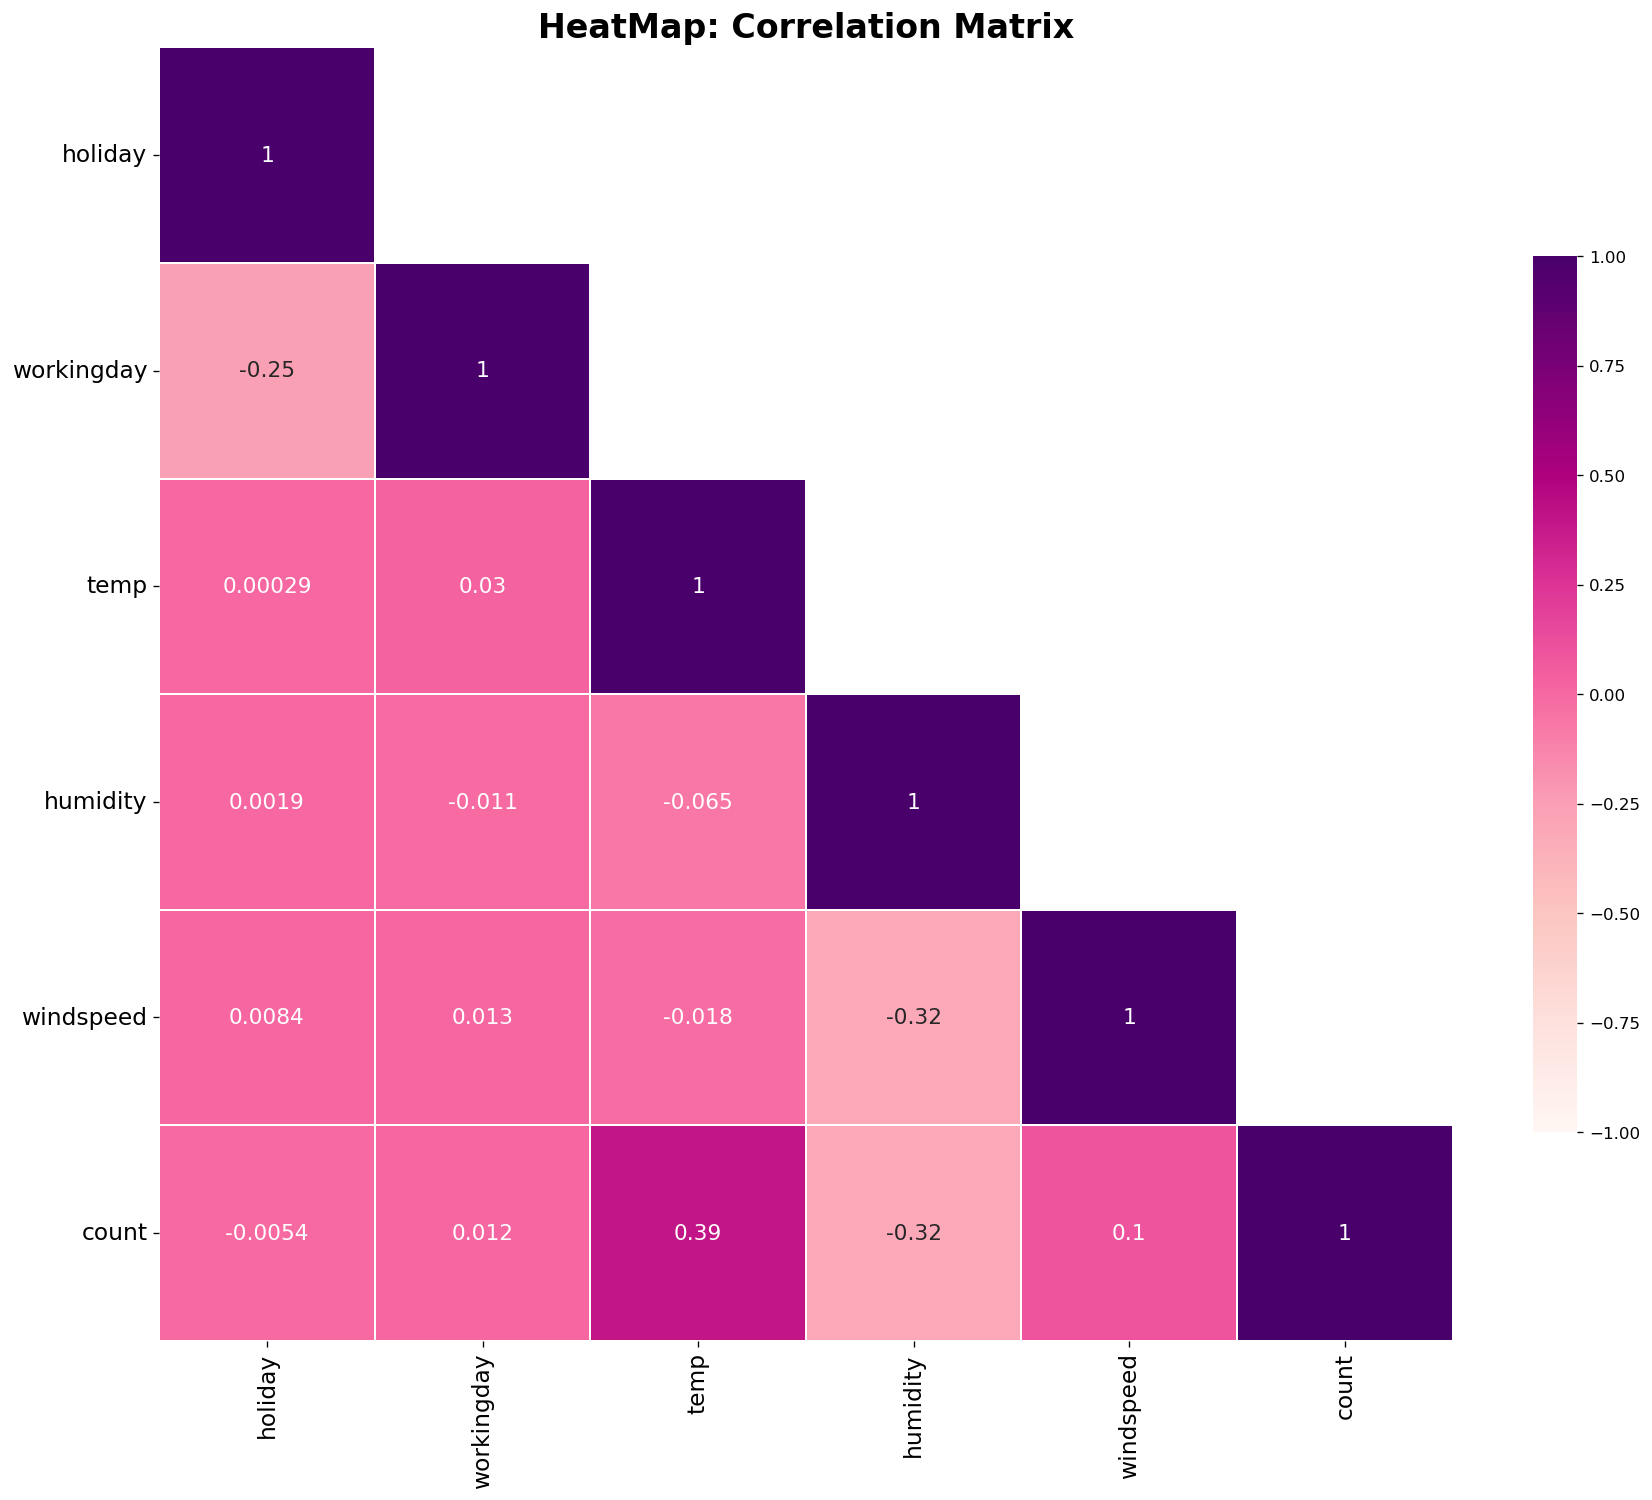

In [71]:
import seaborn as sns

# Selecting only numeric columns (excluding 'casual' and 'registered')
feature_numeric = train.select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_numeric = [i for i in feature_numeric if i not in ['casual', 'registered']]

plt.figure(figsize = (15,15), dpi=120)
corr_data = train.copy()
corr_matrix = corr_data[feature_numeric].corr()

f, ax_corr1 = plt.subplots(figsize=(15, 15), dpi=120)
# Create a mask to eliminate redundant repetitive correlations
corr_mask = np.array(corr_matrix)
corr_mask[np.tril_indices_from(corr_mask)] = False

# Plot heatmap using correlation matrix and mask
ax_corr1 = sns.heatmap(corr_matrix, cmap= 'RdPu', cbar_kws={"shrink": .5}, vmin= -1, vmax=1, center=0,
            square=True, mask=corr_mask, annot=True, linewidths=0.01, annot_kws={"size":13})
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=0)
plt.title("HeatMap: Correlation Matrix", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.autoscale()
plt.show()

In [72]:
# Requirements: (Same settings as that of initial run) For AutoGluon's Tabular Predictions
eval_metric = 'root_mean_squared_error' 
label = 'count'
ignored_columns = ["casual", "registered"]   # Ignored columns while training
train_data = train                           # 'casual' and 'registered' columns are already dropped/ignored
time_limit = 600                             # 10 minutes -> 60*10 = 600 seconds
presets = "best_quality"                     # auto_stack=True
predictor_new_features = TabularPredictor(label=label, 
                                          problem_type= 'regression',
                                          eval_metric=eval_metric, 
                                          learner_kwargs={'ignored_columns': ignored_columns}).fit(
                                                                                           train_data = train_data,
                                                                                           time_limit=time_limit,
                                                                                           presets=presets)

No path specified. Models will be saved in: "AutogluonModels/ag-20240424_131849"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240424_131849"
AutoGluon Version:  0.8.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Mar 23 09:49:55 UTC 2024
Disk Space Avail:   3.79 GB / 5.36 GB (70.7%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    10886
Train Data Columns: 14
Label Column: count
Preprocessing data ...
/opt/conda/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:215: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", 

In [73]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                    model   score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L3  -37.963095       2.661713  52.540497                0.000553           0.131903            3       True          8
1    ExtraTreesMSE_BAG_L2  -37.968146       2.052917  27.488995                0.590207           8.717145            2       True          7
2     WeightedEnsemble_L2  -38.165530       1.160268  18.907293                0.000517           0.202396            2       True          5
3    ExtraTreesMSE_BAG_L1  -38.580226       0.570512   6.223607                0.570512           6.223607            1       True          4
4  RandomForestMSE_BAG_L2  -38.807507       2.070953  43.691449                0.608242          24.919599            2       True          6
5  RandomForestMSE_BAG_L1  -39.717239       0.589239  12.481290                0.58923

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -113.26164315463612,
  'KNeighborsDist_BAG_L1': -109.84517207130654,
  'RandomForestMSE_BAG_L1': -39.71723944004303,
  'ExtraTreesMSE_BAG_L1': -38.58022605268176,
  'WeightedEnsemble_L2': -38.16553007519048,
  'RandomForestMSE_BAG_L2': -38.80750681249569,
  'ExtraTreesMSE_BAG_L2': -37.96814595017891,
  'WeightedEnsemble_L3': -37.9630948317477},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'KNeighborsUnif_BAG_L1': ['KNeighborsUnif_BAG_L1'],
  'KNeighborsDist_BAG_L1': ['KNeighborsDist_BAG_L1'],
  

In [74]:
# Leaderboard dataframe
leaderboard_new_features_df = pd.DataFrame(predictor_new_features.leaderboard(silent=True))
leaderboard_new_features_df

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-37.963095,2.661713,52.540497,0.000553,0.131903,3,True,8
1,ExtraTreesMSE_BAG_L2,-37.968146,2.052917,27.488995,0.590207,8.717145,2,True,7
2,WeightedEnsemble_L2,-38.165530,1.160268,18.907293,0.000517,0.202396,2,True,5
3,ExtraTreesMSE_BAG_L1,-38.580226,0.570512,6.223607,0.570512,6.223607,1,True,4
4,RandomForestMSE_BAG_L2,-38.807507,2.070953,43.691449,0.608242,24.919599,2,True,6
5,RandomForestMSE_BAG_L1,-39.717239,0.589239,12.481290,0.589239,12.481290,1,True,3
6,KNeighborsDist_BAG_L1,-109.845172,0.160312,0.027401,0.160312,0.027401,1,True,2
7,KNeighborsUnif_BAG_L1,-113.261643,0.142648,0.039552,0.142648,0.039552,1,True,1


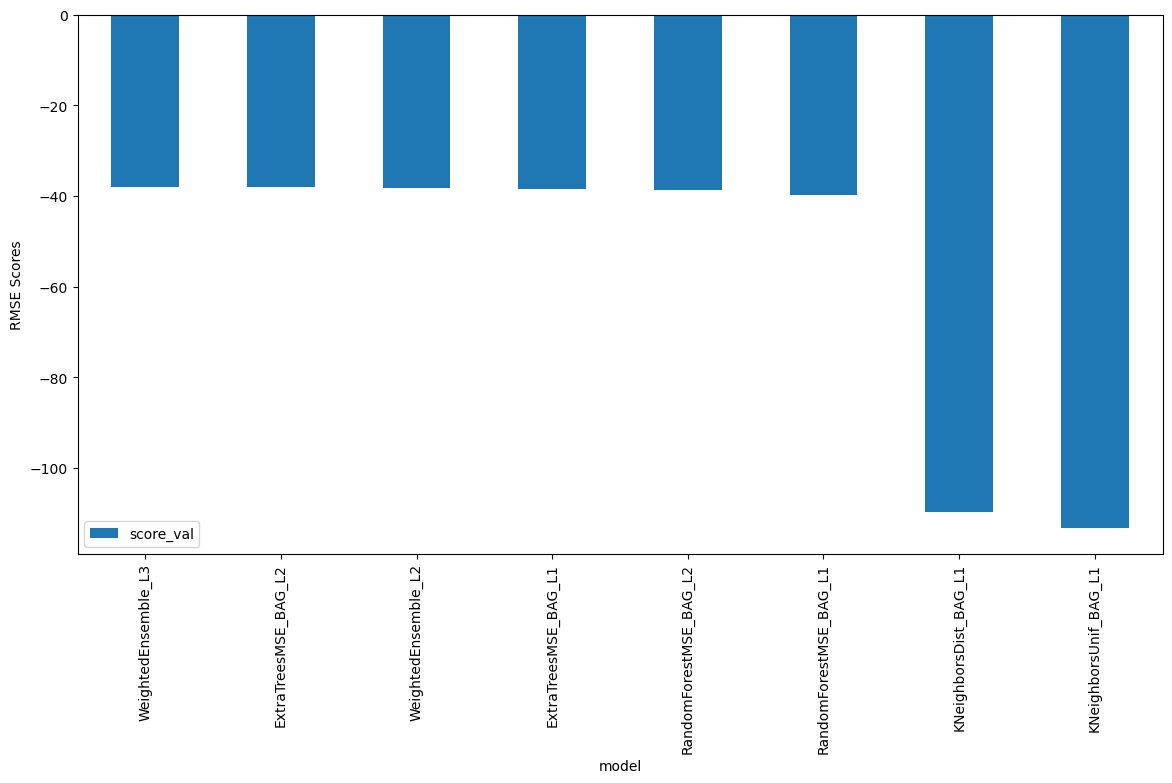

In [75]:
# Output the model's `score_val` in a bar chart to compare performance
import matplotlib.pyplot as plt
leaderboard_new_features_df.plot(kind="bar", x="model", y="score_val", figsize=(14, 7))
plt.ylabel("RMSE Scores")
plt.show()

In [76]:
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    9.065714
1    5.504047
2    3.100238
3    2.667143
4    2.519286
Name: count, dtype: float32

In [77]:
# Describe the `predictions_new_features` series to see if there are any negative values
predictions_new_features.describe()

count    6493.000000
mean      191.113251
std       174.711472
min         1.713095
25%        46.891426
50%       148.867859
75%       282.796661
max       910.689026
Name: count, dtype: float64

In [78]:
# How many negative values do we have?

# Rechecking the predictions in predictions_new_features
negative_pred_count = predictions_new_features.apply(lambda x: 1 if x<0 else 0)

pred_pos_count = (negative_pred_count==0).sum()
pred_neg_count = (negative_pred_count==1).sum()

print("Total predictions                :", len(predictions_new_features.index))
print("Total positive prediction values :", pred_pos_count)
print("Total negative prediction values :", pred_neg_count)

Total predictions                : 6493
Total positive prediction values : 6493
Total negative prediction values : 0


In [79]:
# Remember to set all negative values to zero 
predictions_new_features[predictions_new_features<0] = 0    # (In case, if negative values exist in the predictions_new_features, set them to 0)

# Rechecking, if no predictions are less than 0
negative_pred_count = predictions_new_features.apply(lambda x: 1 if x<0 else 0)
pred_neg_count = (negative_pred_count==1).sum()
print(f"No. of negative predictions: {pred_neg_count}")
print("All negative values in the predictions (if any) are set to zero successfully.")

No. of negative predictions: 0
All negative values in the predictions (if any) are set to zero successfully.


In [80]:
# Same thing as train and test dataset
submission_new_features = pd.read_csv('sampleSubmission.csv', parse_dates = ['datetime'])
submission_new_features.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [131]:
# Same submitting predictions
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)


In [132]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 244kB/s]
Successfully submitted to Bike Sharing Demand

In [133]:

!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 4

fileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_features.csv  2024-04-24 13:55:36  new features                         complete  0.44883      0.44883       
submission_new_features.csv  2024-04-24 13:53:20  new features                         complete  0.44883      0.44883       


In [83]:
# Requirements: (Same settings as initial run) For AutoGluon's Tabular Predictions
eval_metric = 'root_mean_squared_error' 
label = 'count'
ignored_columns = ["casual", "registered"]   # Ignored columns while training
train_data = train                           # 'casual' and 'registered' columns are already dropped/ignored
time_limit = 600                             # 10 minutes -> 60*10 = 600 seconds
presets = "optimize_for_deployment"    

In [84]:
import autogluon.core as ag
## From autogluon documentation

nn_options = {'num_epochs': 5, 
              'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  
                    # learning rate used in training (real-valued hyperparameter searched on log-scale)
              'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  
                    # activation function used in NN (categorical hyperparameter, default = first entry)
              'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1)}

gbm_options = [{'extra_trees': True, 
                'num_boost_round': ag.space.Int(lower=100, upper=500, default=100),
                'num_leaves': ag.space.Int(lower=25, upper=64, default=36),
                'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge']

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options, 
                  }  

num_trials = 20            # Number of hyperparameter optimization trials you want to perform
search_strategy = 'auto'  # tune hyperparameters using Bayesian optimization routine with a local scheduler
scheduler = 'local'       # Local FIFO scheduler

hyperparameter_tune_kwargs = { 
    'num_trials': num_trials,
    'scheduler' : scheduler,
    'searcher': search_strategy,
}

predictor_new_hpo = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error',
                                    learner_kwargs={'ignored_columns': ignored_columns}).fit(
                                                                         train_data=train, 
                                                                         time_limit=time_limit,
                                                                         presets=presets, 
                                                                         hyperparameters=hyperparameters, 
                                                                         hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                                                         refit_full='best')

No path specified. Models will be saved in: "AutogluonModels/ag-20240424_132340"
Presets specified: ['optimize_for_deployment']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240424_132340"
AutoGluon Version:  0.8.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Mar 23 09:49:55 UTC 2024
Disk Space Avail:   2.66 GB / 5.36 GB (49.6%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    10886
Train Data Columns: 14
Label Column: count
Preprocessing data ...
/opt/conda/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:215: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Using Feature Generators to preprocess

  0%|          | 0/20 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
Fitted model: LightGBMXT/T1 ...
	-71.9711	 = Validation score   (-root_mean_squared_error)
	1.75s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: LightGBMXT/T2 ...
	-45.8136	 = Validation score   (-root_mean_squared_error)
	1.27s	 = Training   runtime
	0.07s	 = Validation runtime
Fitted model: LightGBMXT/T3 ...
	-47.839	 = Validation score   (-root_mean_squared_error)
	1.08s	 = Training   runtime
	0.11s	 = Validation runtime
Fitted model: L

  0%|          | 0/20 [00:00<?, ?it/s]

[1000]	valid_set's rmse: 38.8412
[1000]	valid_set's rmse: 39.722
[1000]	valid_set's rmse: 39.5199
[2000]	valid_set's rmse: 38.3691
[3000]	valid_set's rmse: 38.1532
[4000]	valid_set's rmse: 38.1416
[5000]	valid_set's rmse: 38.1845
[1000]	valid_set's rmse: 39.0485
[1000]	valid_set's rmse: 39.3696
[2000]	valid_set's rmse: 38.677
[3000]	valid_set's rmse: 38.6376
[1000]	valid_set's rmse: 38.5283
[2000]	valid_set's rmse: 38.2386
[1000]	valid_set's rmse: 39.1305
[2000]	valid_set's rmse: 38.5694
[3000]	valid_set's rmse: 38.5402
[4000]	valid_set's rmse: 38.4337
[5000]	valid_set's rmse: 38.4924
[1000]	valid_set's rmse: 38.5145
[2000]	valid_set's rmse: 38.3808
[1000]	valid_set's rmse: 40.8581
[2000]	valid_set's rmse: 39.9082
[3000]	valid_set's rmse: 39.509
[4000]	valid_set's rmse: 39.2621
[5000]	valid_set's rmse: 39.0913
[6000]	valid_set's rmse: 39.0335
[7000]	valid_set's rmse: 39.035
[8000]	valid_set's rmse: 39.07
[1000]	valid_set's rmse: 43.5792
[2000]	valid_set's rmse: 41.0624
[3000]	valid_set

	Stopping HPO to satisfy time limit...
Fitted model: LightGBM/T1 ...
	-38.7749	 = Validation score   (-root_mean_squared_error)
	2.83s	 = Training   runtime
	0.43s	 = Validation runtime
Fitted model: LightGBM/T2 ...
	-39.278	 = Validation score   (-root_mean_squared_error)
	1.91s	 = Training   runtime
	0.12s	 = Validation runtime
Fitted model: LightGBM/T3 ...
	-39.6569	 = Validation score   (-root_mean_squared_error)
	2.39s	 = Training   runtime
	0.41s	 = Validation runtime
Fitted model: LightGBM/T4 ...
	-38.124	 = Validation score   (-root_mean_squared_error)
	9.53s	 = Training   runtime
	1.86s	 = Validation runtime
Fitted model: LightGBM/T5 ...
	-39.5392	 = Validation score   (-root_mean_squared_error)
	1.69s	 = Training   runtime
	0.19s	 = Validation runtime
Fitted model: LightGBM/T6 ...
	-39.0408	 = Validation score   (-root_mean_squared_error)
	3.36s	 = Training   runtime
	0.53s	 = Validation runtime
Fitted model: LightGBM/T7 ...
	-38.6204	 = Validation score   (-root_mean_squared

In [85]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2 -37.433966       4.712851  21.733523                0.000455           0.156924            2       True          4
1         LightGBM/T16 -37.844296       2.386134  10.367730                2.386134          10.367730            1       True          1
2         LightGBM/T17 -38.014973       1.886736   8.806469                1.886736           8.806469            1       True          2
3         LightGBM/T19 -38.335105       0.439527   2.402400                0.439527           2.402400            1       True          3
Number of models trained: 4
Types of models trained:
{'WeightedEnsembleModel', 'LGBModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('category', [])  : 3 | ['season', 

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBM/T16': 'LGBModel',
  'LightGBM/T17': 'LGBModel',
  'LightGBM/T19': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM/T16': -37.8442961045261,
  'LightGBM/T17': -38.014972867702795,
  'LightGBM/T19': -38.33510529056697,
  'WeightedEnsemble_L2': -37.43396557587345},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBM/T16': ['LightGBM', 'T16'],
  'LightGBM/T17': ['LightGBM', 'T17'],
  'LightGBM/T19': ['LightGBM', 'T19'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2']},
 'model_fit_times': {'LightGBM/T16': 10.367729902267456,
  'LightGBM/T17': 8.806469440460205,
  'LightGBM/T19': 2.402400255203247,
  'WeightedEnsemble_L2': 0.15692377090454102},
 'model_pred_times': {'LightGBM/T16': 2.3861336708068848,
  'LightGBM/T17': 1.8867359161376953,
  'LightGBM/T19': 0.4395265579223633,
  'WeightedEnsemble_L2': 0.0004546642303466797},
 'num_bag_folds': 0,
 'max_stack_level': 2,
 'model_hyperparams': {'LightGBM/T16'

In [86]:
# Leaderboard dataframe
leaderboard_new_hpo_df = pd.DataFrame(predictor_new_hpo.leaderboard(silent=True))
leaderboard_new_hpo_df

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-37.433966,4.712851,21.733523,0.000455,0.156924,2,True,4
1,LightGBM/T16,-37.844296,2.386134,10.367730,2.386134,10.367730,1,True,1
2,LightGBM/T17,-38.014973,1.886736,8.806469,1.886736,8.806469,1,True,2
3,LightGBM/T19,-38.335105,0.439527,2.402400,0.439527,2.402400,1,True,3


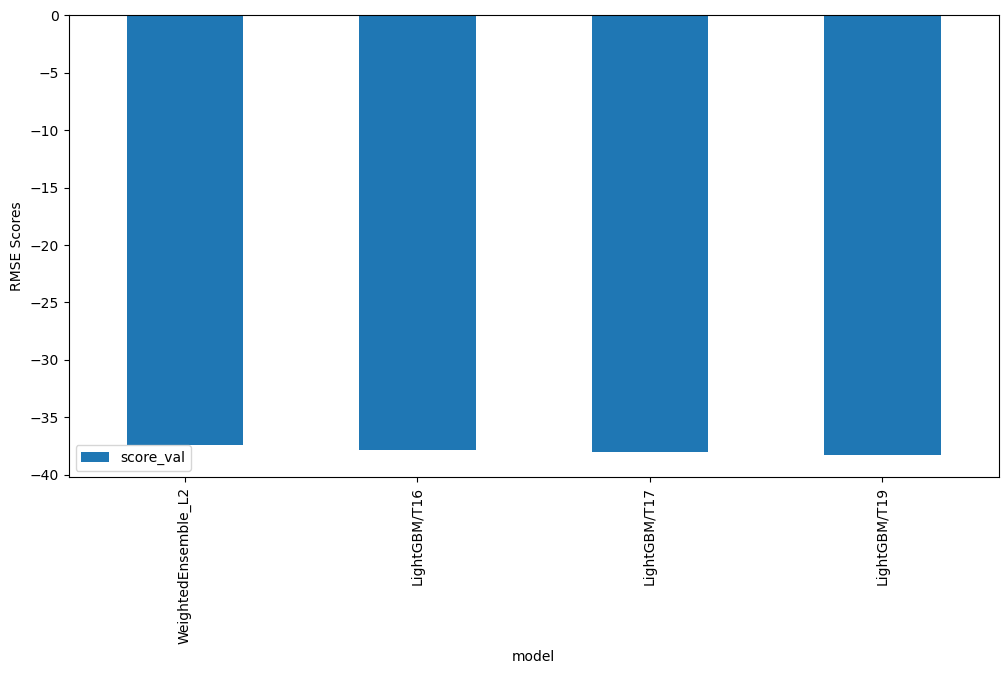

In [87]:
# Output the model's `score_val` in a bar chart to compare performance
import matplotlib.pyplot as plt
leaderboard_new_hpo_df.plot(kind="bar", x="model", y="score_val", figsize=(12, 6))
plt.ylabel("RMSE Scores")
plt.show()

In [88]:
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo.head()

0    20.248280
1     3.000067
2     1.448200
3     2.160984
4     2.098033
Name: count, dtype: float32

In [89]:
# Describe the `predictions_new_hpo` series to see if there are any negative values
predictions_new_hpo.describe()

count    6493.000000
mean      190.091919
std       174.652771
min       -26.579716
25%        45.561981
50%       147.740143
75%       283.975952
max       940.816101
Name: count, dtype: float64

In [90]:
# How many negative values do we have?

# Rechecking the predictions in predictions_new_hpo
negative_pred_count = predictions_new_hpo.apply(lambda x: 1 if x<0 else 0)

pred_pos_count = (negative_pred_count==0).sum()
pred_neg_count = (negative_pred_count==1).sum()

print("Total predictions                :", len(predictions_new_hpo.index))
print("Total positive prediction values :", pred_pos_count)
print("Total negative prediction values :", pred_neg_count)

Total predictions                : 6493
Total positive prediction values : 6390
Total negative prediction values : 103


In [91]:
# Remember to set all negative values to zero 
predictions_new_hpo[predictions_new_hpo<0] = 0    # (In case, if negative values exist in the predictions_new_hpo, set them to 0)

# Rechecking, if no predictions are less than 0
negative_pred_count = predictions_new_hpo.apply(lambda x: 1 if x<0 else 0)
pred_neg_count = (negative_pred_count==1).sum()
print(f"No. of negative predictions: {pred_neg_count}")
print("All negative values in the predictions (if any) are set to zero successfully.")

No. of negative predictions: 0
All negative values in the predictions (if any) are set to zero successfully.


In [92]:
# Same thing as train and test dataset
submission_new_hpo = pd.read_csv('sampleSubmission.csv', parse_dates = ['datetime'])
submission_new_hpo.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [93]:
# Same submitting predictions
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [94]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 237kB/s]
Successfully submitted to Bike Sharing Demand

In [95]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 5

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-04-24 13:29:26  new features with hyperparameters  complete  0.54914      0.54914       
submission_new_features.csv  2024-04-24 13:21:57  new features                       complete  0.44883      0.44883       
sampleSubmission.csv         2024-04-24 13:06:11  first raw submission               complete  4.76188      4.76188       


In [96]:
# Requirements: (Same settings as initial run) For AutoGluon's Tabular Predictions
eval_metric = 'root_mean_squared_error' 
label = 'count'
ignored_columns = ["casual", "registered"]   # Ignored columns while training
train_data = train                           # 'casual' and 'registered' columns are already dropped/ignored
time_limit = 600                             # 10 minutes -> 600 seconds
presets = "optimize_for_deployment"          # Lighter preset options (faster)

In [97]:
import autogluon.core as ag
## From autogluon documentation: 

# Exclude ['NN_TORCH'] family of models
excluded_model_types = ['NN_TORCH']


# Considering GBM, XT and XGB model types (as these along with WeightedEnsembles have shown good results)
# For GBM
gbm_options = [{'extra_trees': True, 
                'num_boost_round': ag.space.Int(lower=100, upper=800, default=100),
                'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
                'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge']

# XT Models
xt_options = {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}}

# XGB Models
xgb_options = [{'objective': 'reg:squarederror', # 'reg:linear' is deprecated
                'eval_metric': 'rmse', 
                'max_depth':ag.space.Int(lower=5, upper=8, default=6), 
                'n_estimators': ag.space.Int(lower=100, upper=500, default=100), 
                'eta':.3, 
                'subsample': 1,
                'colsample_bytree': 1}]

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'XT': xt_options,
                   'XGB': xgb_options
                  }  

num_trials = 20            # Number of hyperparameter optimization trials you want to perform
search_strategy = 'auto'  # tune hyperparameters using Bayesian optimization routine with a local scheduler
scheduler = 'local'       # Local FIFO scheduler

hyperparameter_tune_kwargs = { 
                            'num_trials': num_trials,
                            'scheduler' : scheduler,
                            'searcher': search_strategy,
                        }

predictor_new_hpo1 = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error',
                                    learner_kwargs={'ignored_columns': ignored_columns}).fit(
                                                                         train_data=train, 
                                                                         time_limit=time_limit,
                                                                         presets=presets, 
                                                                         hyperparameters=hyperparameters, 
                                                                         hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                                                         excluded_model_types=excluded_model_types,
                                                                         refit_full='best')

No path specified. Models will be saved in: "AutogluonModels/ag-20240424_133011"
Presets specified: ['optimize_for_deployment']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240424_133011"
AutoGluon Version:  0.8.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Mar 23 09:49:55 UTC 2024
Disk Space Avail:   2.59 GB / 5.36 GB (48.3%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    10886
Train Data Columns: 14
Label Column: count
Preprocessing data ...
/opt/conda/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:215: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Using Feature Generators to preprocess

  0%|          | 0/20 [00:00<?, ?it/s]

Fitted model: LightGBMXT/T1 ...
	-71.9711	 = Validation score   (-root_mean_squared_error)
	0.62s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: LightGBMXT/T2 ...
	-43.8633	 = Validation score   (-root_mean_squared_error)
	0.92s	 = Training   runtime
	0.09s	 = Validation runtime
Fitted model: LightGBMXT/T3 ...
	-88.1544	 = Validation score   (-root_mean_squared_error)
	0.62s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: LightGBMXT/T4 ...
	-50.4195	 = Validation score   (-root_mean_squared_error)
	1.36s	 = Training   runtime
	0.21s	 = Validation runtime
Fitted model: LightGBMXT/T5 ...
	-90.0782	 = Validation score   (-root_mean_squared_error)
	0.58s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: LightGBMXT/T6 ...
	-58.3299	 = Validation score   (-root_mean_squared_error)
	0.95s	 = Training   runtime
	0.1s	 = Validation runtime
Fitted model: LightGBMXT/T7 ...
	-40.3716	 = Validation score   (-root_mean_squared_error)
	1.46s	 = Traini

  0%|          | 0/20 [00:00<?, ?it/s]

[1000]	valid_set's rmse: 38.8412
[1000]	valid_set's rmse: 39.722
[1000]	valid_set's rmse: 39.5199
[2000]	valid_set's rmse: 38.3691
[3000]	valid_set's rmse: 38.1532
[4000]	valid_set's rmse: 38.1416
[5000]	valid_set's rmse: 38.1845
[1000]	valid_set's rmse: 39.0485
[1000]	valid_set's rmse: 39.3696
[2000]	valid_set's rmse: 38.677
[3000]	valid_set's rmse: 38.6376
[1000]	valid_set's rmse: 38.5283
[2000]	valid_set's rmse: 38.2386
[1000]	valid_set's rmse: 39.1305
[2000]	valid_set's rmse: 38.5694
[3000]	valid_set's rmse: 38.5402
[4000]	valid_set's rmse: 38.4337
[5000]	valid_set's rmse: 38.4924
[1000]	valid_set's rmse: 38.5145
[2000]	valid_set's rmse: 38.3808
[1000]	valid_set's rmse: 40.8581
[2000]	valid_set's rmse: 39.9082
[3000]	valid_set's rmse: 39.509
[4000]	valid_set's rmse: 39.2621
[5000]	valid_set's rmse: 39.0913
[6000]	valid_set's rmse: 39.0335
[7000]	valid_set's rmse: 39.035
[8000]	valid_set's rmse: 39.07
[1000]	valid_set's rmse: 43.5792
[2000]	valid_set's rmse: 41.0624
[3000]	valid_set

	Ran out of time, early stopping on iteration 1895. Best iteration is:
	[1895]	valid_set's rmse: 38.4017
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM/T1 ...
	-38.7749	 = Validation score   (-root_mean_squared_error)
	1.67s	 = Training   runtime
	0.26s	 = Validation runtime
Fitted model: LightGBM/T2 ...
	-39.278	 = Validation score   (-root_mean_squared_error)
	1.19s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: LightGBM/T3 ...
	-39.6569	 = Validation score   (-root_mean_squared_error)
	2.02s	 = Training   runtime
	0.32s	 = Validation runtime
Fitted model: LightGBM/T4 ...
	-38.124	 = Validation score   (-root_mean_squared_error)
	9.51s	 = Training   runtime
	1.94s	 = Validation runtime
Fitted model: LightGBM/T5 ...
	-39.5392	 = Validation score   (-root_mean_squared_error)
	1.8s	 = Training   runtime
	0.21s	 = Validation runtime
Fitted model: LightGBM/T6 ...
	-39.0408	 = Validation score   (-root_mean_squared_error)
	3.86s	 = Training   runtime
	0.62s

  0%|          | 0/20 [00:00<?, ?it/s]

Fitted model: XGBoost/T1 ...
	-41.7563	 = Validation score   (-root_mean_squared_error)
	0.42s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: XGBoost/T2 ...
	-40.9482	 = Validation score   (-root_mean_squared_error)
	1.13s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: XGBoost/T3 ...
	-40.1906	 = Validation score   (-root_mean_squared_error)
	1.17s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: XGBoost/T4 ...
	-45.25	 = Validation score   (-root_mean_squared_error)
	0.48s	 = Training   runtime
	0.03s	 = Validation runtime
Fitted model: XGBoost/T5 ...
	-44.6192	 = Validation score   (-root_mean_squared_error)
	1.23s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: XGBoost/T6 ...
	-40.6271	 = Validation score   (-root_mean_squared_error)
	0.96s	 = Training   runtime
	0.05s	 = Validation runtime
Fitted model: XGBoost/T7 ...
	-43.0461	 = Validation score   (-root_mean_squared_error)
	0.71s	 = Training   runtime
	0.04s	 =

In [98]:
predictor_new_hpo1.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2 -37.274505       3.377855  23.059375                0.000649           0.390262            2       True          6
1         LightGBM/T16 -37.844296       2.063207  10.242136                2.063207          10.242136            1       True          2
2         LightGBM/T13 -38.369670       0.676737   4.052137                0.676737           4.052137            1       True          1
3          XGBoost/T19 -38.740239       0.048002   1.182843                0.048002           1.182843            1       True          5
4           XGBoost/T8 -39.384803       0.076230   1.669881                0.076230           1.669881            1       True          4
5        ExtraTreesMSE -39.584076       0.513030   5.522115                0.513030           5.522115        

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBM/T13': 'LGBModel',
  'LightGBM/T16': 'LGBModel',
  'ExtraTreesMSE': 'XTModel',
  'XGBoost/T8': 'XGBoostModel',
  'XGBoost/T19': 'XGBoostModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM/T13': -38.3696701247306,
  'LightGBM/T16': -37.8442961045261,
  'ExtraTreesMSE': -39.584076050325685,
  'XGBoost/T8': -39.38480317646934,
  'XGBoost/T19': -38.7402388682388,
  'WeightedEnsemble_L2': -37.27450485876748},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBM/T13': ['LightGBM', 'T13'],
  'LightGBM/T16': ['LightGBM', 'T16'],
  'ExtraTreesMSE': ['ExtraTreesMSE'],
  'XGBoost/T8': ['XGBoost', 'T8'],
  'XGBoost/T19': ['XGBoost', 'T19'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2']},
 'model_fit_times': {'LightGBM/T13': 4.0521368980407715,
  'LightGBM/T16': 10.242136478424072,
  'ExtraTreesMSE': 5.522115230560303,
  'XGBoost/T8': 1.6698808670043945,
  'XGBoost/T19': 1.1828434467315674,
  'WeightedEnsemble_L2': 0.3

In [99]:
# Leaderboard dataframe
leaderboard_new_hpo1_df = pd.DataFrame(predictor_new_hpo1.leaderboard(silent=True))
leaderboard_new_hpo1_df

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-37.274505,3.377855,23.059375,0.000649,0.390262,2,True,6
1,LightGBM/T16,-37.844296,2.063207,10.242136,2.063207,10.242136,1,True,2
2,LightGBM/T13,-38.369670,0.676737,4.052137,0.676737,4.052137,1,True,1
3,XGBoost/T19,-38.740239,0.048002,1.182843,0.048002,1.182843,1,True,5
4,XGBoost/T8,-39.384803,0.076230,1.669881,0.076230,1.669881,1,True,4
5,ExtraTreesMSE,-39.584076,0.513030,5.522115,0.513030,5.522115,1,True,3


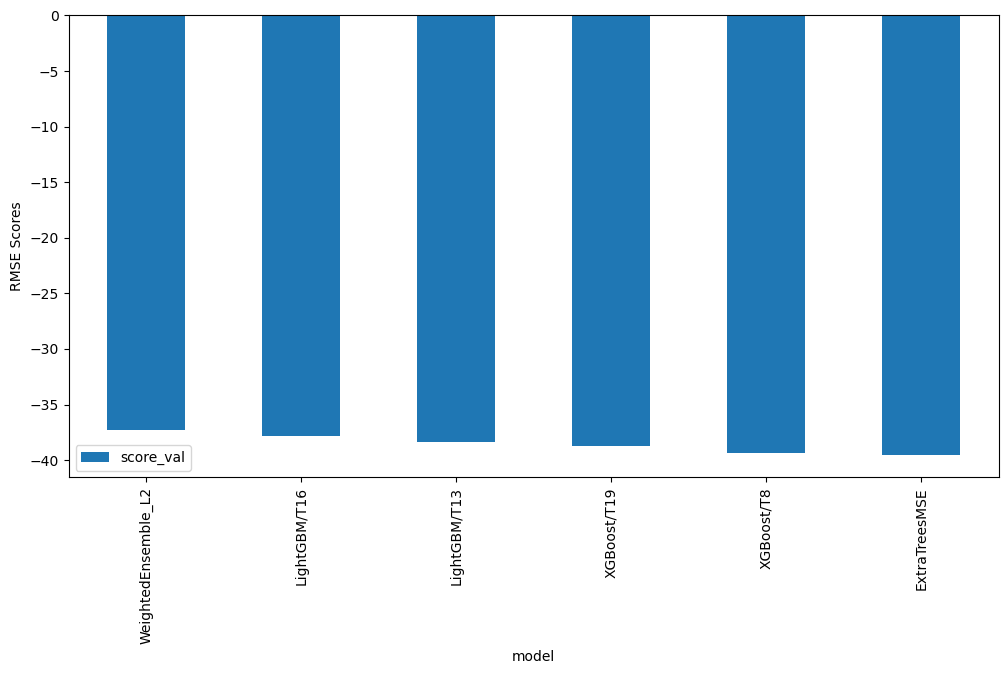

In [100]:
# Output the model's `score_val` in a bar chart to compare performance
import matplotlib.pyplot as plt
leaderboard_new_hpo1_df.plot(kind="bar", x="model", y="score_val", figsize=(12, 6))
plt.ylabel("RMSE Scores")
plt.show()

In [101]:
predictions_new_hpo1 = predictor_new_hpo1.predict(test)
predictions_new_hpo1.head()

0    17.015160
1     2.912074
2     1.076082
3     1.954710
4     2.003743
Name: count, dtype: float32

In [102]:
# How many negative values do we have?

# Rechecking the predictions in predictions_new_hpo1
negative_pred_count = predictions_new_hpo1.apply(lambda x: 1 if x<0 else 0)

pred_pos_count = (negative_pred_count==0).sum()
pred_neg_count = (negative_pred_count==1).sum()

print("Total predictions                :", len(predictions_new_hpo1.index))
print("Total positive prediction values :", pred_pos_count)
print("Total negative prediction values :", pred_neg_count)

Total predictions                : 6493
Total positive prediction values : 6438
Total negative prediction values : 55


In [103]:
# Remember to set all negative values to zero 
predictions_new_hpo1[predictions_new_hpo1<0] = 0    # (In case, if negative values exist in the predictions_new_hpo1, set them to 0)

# Rechecking, if no predictions are less than 0
negative_pred_count = predictions_new_hpo1.apply(lambda x: 1 if x<0 else 0)
pred_neg_count = (negative_pred_count==1).sum()
print(f"No.of negative predictions: {pred_neg_count}")
print("All negative values in the predictions (if any) are set to zero successfully.")

No.of negative predictions: 0
All negative values in the predictions (if any) are set to zero successfully.


In [104]:
# Same thing as train and test dataset
submission_new_hpo1 = pd.read_csv('sampleSubmission.csv', parse_dates = ['datetime'])
submission_new_hpo1.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [105]:
# Same submitting predictions
submission_new_hpo1["count"] = predictions_new_hpo1
submission_new_hpo1.to_csv("submission_new_hpo1.csv", index=False)

In [106]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo1.csv -m "new features with hyperparameters 1"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 325kB/s]
Successfully submitted to Bike Sharing Demand

In [107]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_hpo1.csv      2024-04-24 13:35:52  new features with hyperparameters 1  complete  0.50546      0.50546       
submission_new_hpo.csv       2024-04-24 13:29:26  new features with hyperparameters    complete  0.54914      0.54914       
submission_new_features.csv  2024-04-24 13:21:57  new features                         complete  0.44883      0.44883       
sampleSubmission.csv         2024-04-24 13:06:11  first raw submission                 complete  4.76188      4.76188       


In [108]:
# Requirements: (Same settings as initial run) For AutoGluon's Tabular Predictions
eval_metric = 'root_mean_squared_error' 
label = 'count'
ignored_columns = ["casual", "registered"]   # Ignored columns while training
train_data = train                           # 'casual' and 'registered' columns are already dropped/ignored
time_limit = 600                             # 10 minutes -> 600 seconds
presets = "optimize_for_deployment"        

In [109]:
import autogluon.core as ag
## From autogluon documentation

# Exclude ['NN_TORCH'] family of models
excluded_model_types = ['NN_TORCH']


# Considering GBM, XT, XGB, KNN and RF model types (as these along with WeightedEnsembles have shown good results in the past)
# For GBM
gbm_options = [{'extra_trees': True, 
                'num_boost_round': ag.space.Int(lower=100, upper=800, default=100),
                'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
                'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge']
# XT Models
xt_options = {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}}
# XGB Models
xgb_options = [{'objective': 'reg:squarederror', # 'reg:linear' is deprecated
                'eval_metric': 'rmse', 
                'max_depth':ag.space.Int(lower=5, upper=8, default=6), 
                'n_estimators': ag.space.Int(lower=100, upper=500, default=100), 
                'eta':.3, 
                'subsample': 1,
                'colsample_bytree': 1}]
# Random Forest Models
rf_options = {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}}
# KNN
knn_options = [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Uniform'}}, 
               {'weights': 'distance', 'ag_args': {'name_suffix': 'Distance'}}]  # default

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'KNN': knn_options,
                   'XT': xt_options,
                   'XGB': xgb_options,
                   'RF': rf_options
                  }  


num_trials = 20            # Number of hyperparameter optimization trials you want to perform
search_strategy = 'auto'  # tune hyperparameters using Bayesian optimization routine with a local scheduler
scheduler = 'local'       # Local FIFO scheduler

hyperparameter_tune_kwargs = { 
                            'num_trials': num_trials,
                            'scheduler' : scheduler,
                            'searcher': search_strategy,
                        }


predictor_new_hpo2 = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error',
                                    learner_kwargs={'ignored_columns': ignored_columns}).fit(
                                                                         train_data=train, 
                                                                         time_limit=time_limit,
                                                                         presets=presets, 
                                                                         hyperparameters=hyperparameters, 
                                                                         hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                                                         excluded_model_types=excluded_model_types,
                                                                         refit_full='best')

No path specified. Models will be saved in: "AutogluonModels/ag-20240424_133700"
Presets specified: ['optimize_for_deployment']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240424_133700"
AutoGluon Version:  0.8.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Mar 23 09:49:55 UTC 2024
Disk Space Avail:   2.31 GB / 5.36 GB (43.1%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    10886
Train Data Columns: 14
Label Column: count
Preprocessing data ...
/opt/conda/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:215: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Using Feature Generators to preprocess

  0%|          | 0/20 [00:00<?, ?it/s]

Fitted model: LightGBMXT/T1 ...
	-71.9711	 = Validation score   (-root_mean_squared_error)
	0.63s	 = Training   runtime
	0.03s	 = Validation runtime
Fitted model: LightGBMXT/T2 ...
	-43.8633	 = Validation score   (-root_mean_squared_error)
	1.34s	 = Training   runtime
	0.1s	 = Validation runtime
Fitted model: LightGBMXT/T3 ...
	-88.1544	 = Validation score   (-root_mean_squared_error)
	0.7s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: LightGBMXT/T4 ...
	-50.4195	 = Validation score   (-root_mean_squared_error)
	1.51s	 = Training   runtime
	0.25s	 = Validation runtime
Fitted model: LightGBMXT/T5 ...
	-90.0782	 = Validation score   (-root_mean_squared_error)
	0.66s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: LightGBMXT/T6 ...
	-58.3299	 = Validation score   (-root_mean_squared_error)
	1.14s	 = Training   runtime
	0.12s	 = Validation runtime
Fitted model: LightGBMXT/T7 ...
	-40.3716	 = Validation score   (-root_mean_squared_error)
	2.11s	 = Trainin

  0%|          | 0/20 [00:00<?, ?it/s]

[1000]	valid_set's rmse: 38.8412
[1000]	valid_set's rmse: 39.722
[1000]	valid_set's rmse: 39.5199
[2000]	valid_set's rmse: 38.3691
[3000]	valid_set's rmse: 38.1532
[4000]	valid_set's rmse: 38.1416
[5000]	valid_set's rmse: 38.1845
[1000]	valid_set's rmse: 39.0485
[1000]	valid_set's rmse: 39.3696
[2000]	valid_set's rmse: 38.677
[3000]	valid_set's rmse: 38.6376
[1000]	valid_set's rmse: 38.5283
[2000]	valid_set's rmse: 38.2386
[1000]	valid_set's rmse: 39.1305
[2000]	valid_set's rmse: 38.5694
[3000]	valid_set's rmse: 38.5402
[4000]	valid_set's rmse: 38.4337
[5000]	valid_set's rmse: 38.4924


	Ran out of time, early stopping on iteration 577. Best iteration is:
	[577]	valid_set's rmse: 39.4309
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM/T1 ...
	-38.7749	 = Validation score   (-root_mean_squared_error)
	1.94s	 = Training   runtime
	0.3s	 = Validation runtime
Fitted model: LightGBM/T2 ...
	-39.278	 = Validation score   (-root_mean_squared_error)
	1.31s	 = Training   runtime
	0.07s	 = Validation runtime
Fitted model: LightGBM/T3 ...
	-39.6569	 = Validation score   (-root_mean_squared_error)
	2.33s	 = Training   runtime
	0.38s	 = Validation runtime
Fitted model: LightGBM/T4 ...
	-38.124	 = Validation score   (-root_mean_squared_error)
	9.19s	 = Training   runtime
	1.87s	 = Validation runtime
Fitted model: LightGBM/T5 ...
	-39.5392	 = Validation score   (-root_mean_squared_error)
	1.54s	 = Training   runtime
	0.17s	 = Validation runtime
Fitted model: LightGBM/T6 ...
	-39.0408	 = Validation score   (-root_mean_squared_error)
	3.41s	 = Training   runtime
	0.5s	 =

  0%|          | 0/20 [00:00<?, ?it/s]

Fitted model: XGBoost/T1 ...
	-41.7563	 = Validation score   (-root_mean_squared_error)
	0.34s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: XGBoost/T2 ...
	-40.9482	 = Validation score   (-root_mean_squared_error)
	1.13s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: XGBoost/T3 ...
	-40.1906	 = Validation score   (-root_mean_squared_error)
	1.19s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: XGBoost/T4 ...
	-45.25	 = Validation score   (-root_mean_squared_error)
	0.48s	 = Training   runtime
	0.03s	 = Validation runtime
Fitted model: XGBoost/T5 ...
	-44.6192	 = Validation score   (-root_mean_squared_error)
	1.36s	 = Training   runtime
	0.1s	 = Validation runtime
Fitted model: XGBoost/T6 ...
	-40.6271	 = Validation score   (-root_mean_squared_error)
	1.13s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: XGBoost/T7 ...
	-43.0461	 = Validation score   (-root_mean_squared_error)
	0.92s	 = Training   runtime
	0.04s	 = 

In [110]:
predictor_new_hpo2.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2 -37.141685       5.118596  32.154655                0.000492           0.377405            2       True          8
1          LightGBM/T4 -38.124006       1.868271   9.190561                1.868271           9.190561            1       True          1
2         LightGBM/T12 -38.431862       2.246799   9.227602                2.246799           9.227602            1       True          3
3        LightGBMLarge -38.516436       0.267625   2.561496                0.267625           2.561496            1       True          7
4         LightGBM/T10 -38.559673       0.047817   1.089823                0.047817           1.089823            1       True          2
5          XGBoost/T19 -38.740239       0.065415   1.609944                0.065415           1.609944        

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBM/T4': 'LGBModel',
  'LightGBM/T10': 'LGBModel',
  'LightGBM/T12': 'LGBModel',
  'ExtraTreesMSE': 'XTModel',
  'XGBoost/T8': 'XGBoostModel',
  'XGBoost/T19': 'XGBoostModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM/T4': -38.12400606131232,
  'LightGBM/T10': -38.55967268294494,
  'LightGBM/T12': -38.431861570431245,
  'ExtraTreesMSE': -39.584076050325685,
  'XGBoost/T8': -39.38480317646934,
  'XGBoost/T19': -38.7402388682388,
  'LightGBMLarge': -38.51643622165731,
  'WeightedEnsemble_L2': -37.141684762005944},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBM/T4': ['LightGBM', 'T4'],
  'LightGBM/T10': ['LightGBM', 'T10'],
  'LightGBM/T12': ['LightGBM', 'T12'],
  'ExtraTreesMSE': ['ExtraTreesMSE'],
  'XGBoost/T8': ['XGBoost', 'T8'],
  'XGBoost/T19': ['XGBoost', 'T19'],
  'LightGBMLarge': ['LightGBMLarge'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2']},
 'model_fit_times':

In [111]:
# Leaderboard dataframe
leaderboard_new_hpo2_df = pd.DataFrame(predictor_new_hpo2.leaderboard(silent=True))
leaderboard_new_hpo2_df

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-37.141685,5.118596,32.154655,0.000492,0.377405,2,True,8
1,LightGBM/T4,-38.124006,1.868271,9.190561,1.868271,9.190561,1,True,1
2,LightGBM/T12,-38.431862,2.246799,9.227602,2.246799,9.227602,1,True,3
3,LightGBMLarge,-38.516436,0.267625,2.561496,0.267625,2.561496,1,True,7
4,LightGBM/T10,-38.559673,0.047817,1.089823,0.047817,1.089823,1,True,2
5,XGBoost/T19,-38.740239,0.065415,1.609944,0.065415,1.609944,1,True,6
6,XGBoost/T8,-39.384803,0.114050,2.254590,0.114050,2.254590,1,True,5
7,ExtraTreesMSE,-39.584076,0.508128,5.843234,0.508128,5.843234,1,True,4


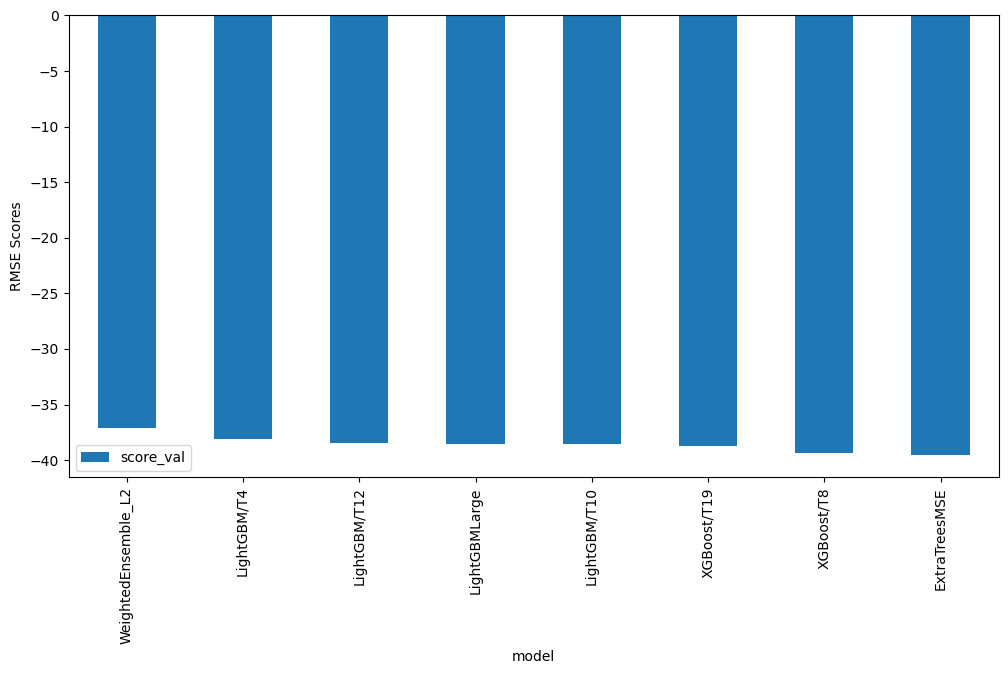

In [112]:
# Output the model's `score_val` in a bar chart to compare performance
import matplotlib.pyplot as plt
leaderboard_new_hpo2_df.plot(kind="bar", x="model", y="score_val", figsize=(12, 6))
plt.ylabel("RMSE Scores")
plt.show()

In [113]:
predictions_new_hpo2 = predictor_new_hpo2.predict(test)
predictions_new_hpo2.head()

0    17.262060
1     3.898512
2     2.161075
3     1.608736
4     1.636371
Name: count, dtype: float32

In [114]:
# Describe the `predictions_new_hpo2` series to see if there are any negative values
predictions_new_hpo2.describe()

count    6493.000000
mean      190.536255
std       173.844864
min       -14.561037
25%        46.690876
50%       148.963791
75%       283.369751
max       939.479248
Name: count, dtype: float64

In [115]:
# How many negative values do we have?

# Rechecking the predictions in predictions_new_hpo2
negative_pred_count = predictions_new_hpo2.apply(lambda x: 1 if x<0 else 0)

pred_pos_count = (negative_pred_count==0).sum()
pred_neg_count = (negative_pred_count==1).sum()

print("Total predictions                :", len(predictions_new_hpo2.index))
print("Total positive prediction values :", pred_pos_count)
print("Total negative prediction values :", pred_neg_count)

Total predictions                : 6493
Total positive prediction values : 6440
Total negative prediction values : 53


In [117]:
# Remember to set all negative values to zero 
predictions_new_hpo2[predictions_new_hpo2<0] = 0    # (In case, if negative values exist in the predictions_new_hpo2, set them to 0)

# Rechecking, if no predictions are less than 0
negative_pred_count = predictions_new_hpo2.apply(lambda x: 1 if x<0 else 0)
pred_neg_count = (negative_pred_count==1).sum()
print(f"No. of negative predictions: {pred_neg_count}")
print("All negative values in the predictions (if any) are set to zero successfully.")

No. of negative predictions: 0
All negative values in the predictions (if any) are set to zero successfully.


In [118]:
# Same thing as train and test dataset
submission_new_hpo2 = pd.read_csv('sampleSubmission.csv', parse_dates = ['datetime'])
submission_new_hpo2.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [119]:
# Same submitting predictions
submission_new_hpo2["count"] = predictions_new_hpo2
submission_new_hpo2.to_csv("submission_new_hpo2.csv", index=False)

In [120]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo2.csv -m "new features with hyperparameters 2"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 240kB/s]
Successfully submitted to Bike Sharing Demand

In [121]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 7

fileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_hpo2.csv      2024-04-24 13:42:17  new features with hyperparameters 2  complete  0.4993       0.4993        
submission_new_hpo1.csv      2024-04-24 13:35:52  new features with hyperparameters 1  complete  0.50546      0.50546       
submission_new_hpo.csv       2024-04-24 13:29:26  new features with hyperparameters    complete  0.54914      0.54914       
submission_new_features.csv  2024-04-24 13:21:57  new features                         complete  0.44883      0.44883       
sampleSubmission.csv         2024-04-24 13:06:11  first raw submission                 complete  4.76188      4.76188       


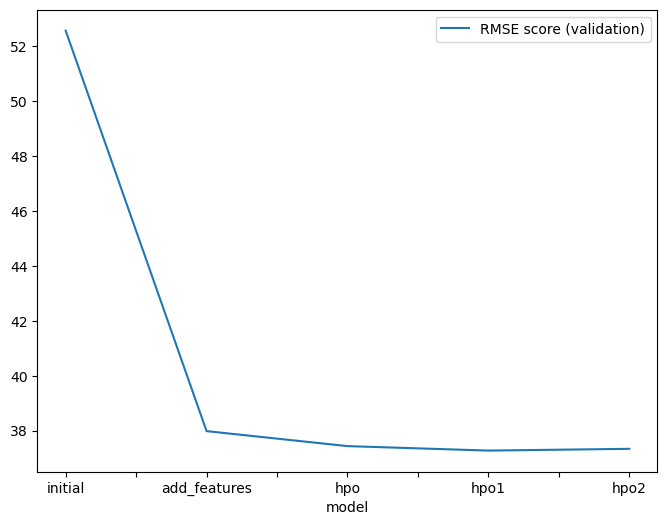

In [128]:
#Step 7: Write a Report
#Refer to the markdown file for the full report
#Creating plots and table for report
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)

fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo", "hpo1", "hpo2"], 
        "RMSE score (validation)": [52.5564, 37.9800, 37.4340, 37.2718, 37.3353]  # Note: Actual RMSE values are considered
    }
).plot(x="model", y="RMSE score (validation)", figsize=(8, 6)).get_figure()


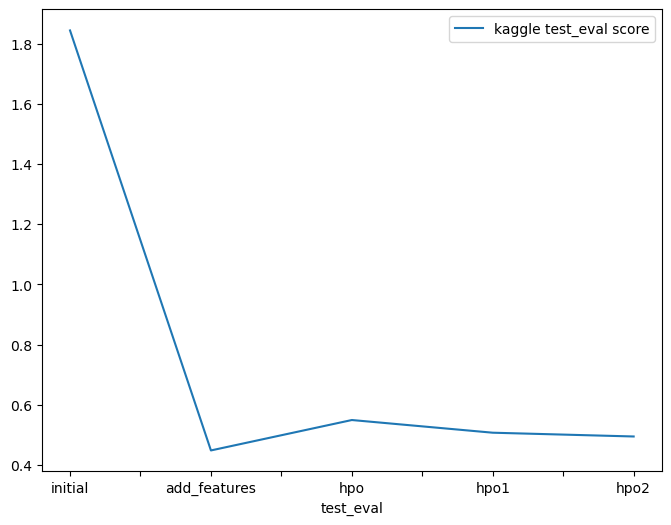

In [127]:
# Take the 3 kaggle scores (or more) and create a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo", "hpo1", "hpo2"],  
        "kaggle test_eval score": [1.84484, 0.44798, 0.54914, 0.50695, 0.49440]
    }
).plot(x="test_eval", y="kaggle test_eval score", figsize=(8, 6)).get_figure()


In [126]:
# The 3 hyperparameters we tuned with the kaggle score as the result

# NOTE: Here the last 'hpo' based top-model is the 'hpo2' model with best Kaggle score within hyperparameter optimization category
pd.DataFrame({
    "model": ["initial", "add_features", "hpo (top-hpo-model: hpo2)"],
    "hpo1": ["prescribed_values", "prescribed_values", "Tree-Based Models: (GBM, XT, XGB & RF)"],
    "hpo2": ["prescribed_values", "prescribed_values", "KNN"],
    "hpo3": ["presets: 'high quality' (auto_stack=True)", "presets: 'high quality' (auto_stack=True)", "presets: 'optimize_for_deployment"],
    "score": [1.84484, 0.44798, 0.49440]
})

,model,hpo1,hpo2,hpo3,score
0,initial,prescribed_values,prescribed_values,presets: 'high quality' (auto_stack=True),1.84484
1,add_features,prescribed_values,prescribed_values,presets: 'high quality' (auto_stack=True),0.44798
2,hpo (top-hpo-model: hpo2),"Tree-Based Models: (GBM, XT, XGB & RF)",KNN,presets: 'optimize_for_deployment,0.49440


In [ ]:
#Conclusion:
#The top-ranked model was the (add features) model named WeightedEnsemble_L3, 
#with a validation RMSE score of 37.9800 and the best Kaggle score of 0.44798 (on test dataset).